# Partial Differential Equations

There are several techniques for solving PDEs and we could spend the entire course working on this.  We will just cover the use of difference equations.  We look at the description in Numerical Recipes:

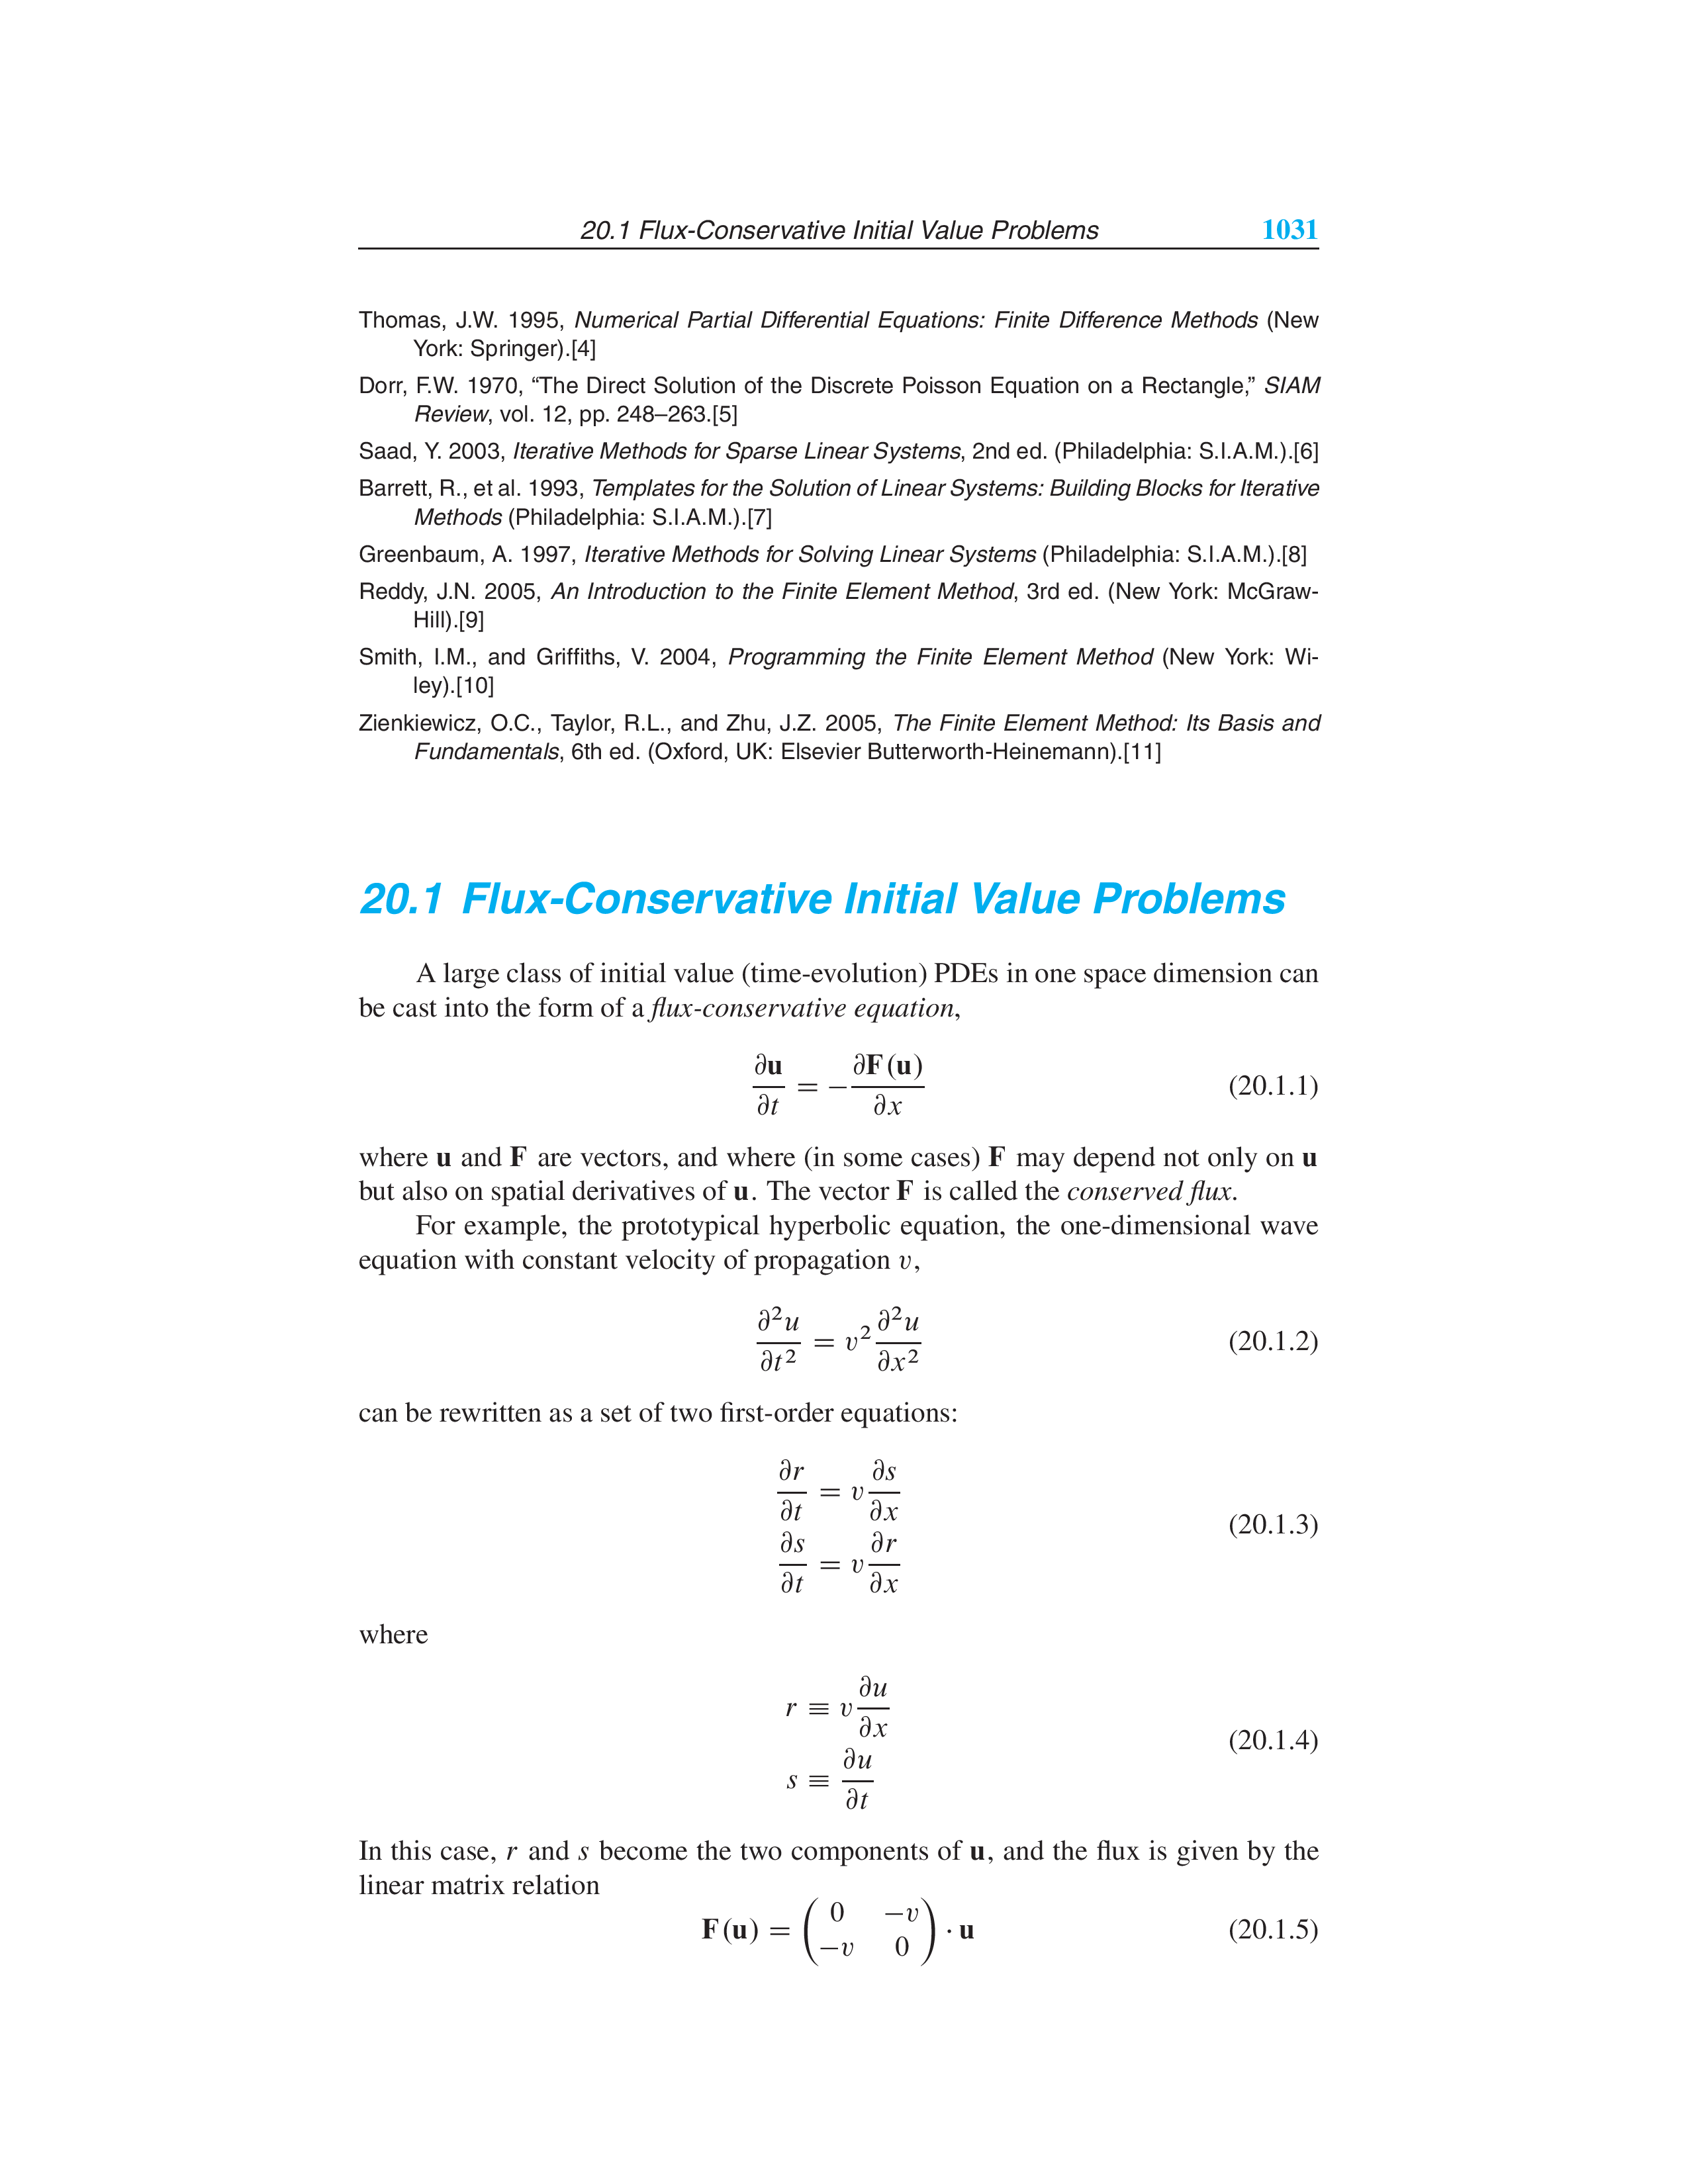
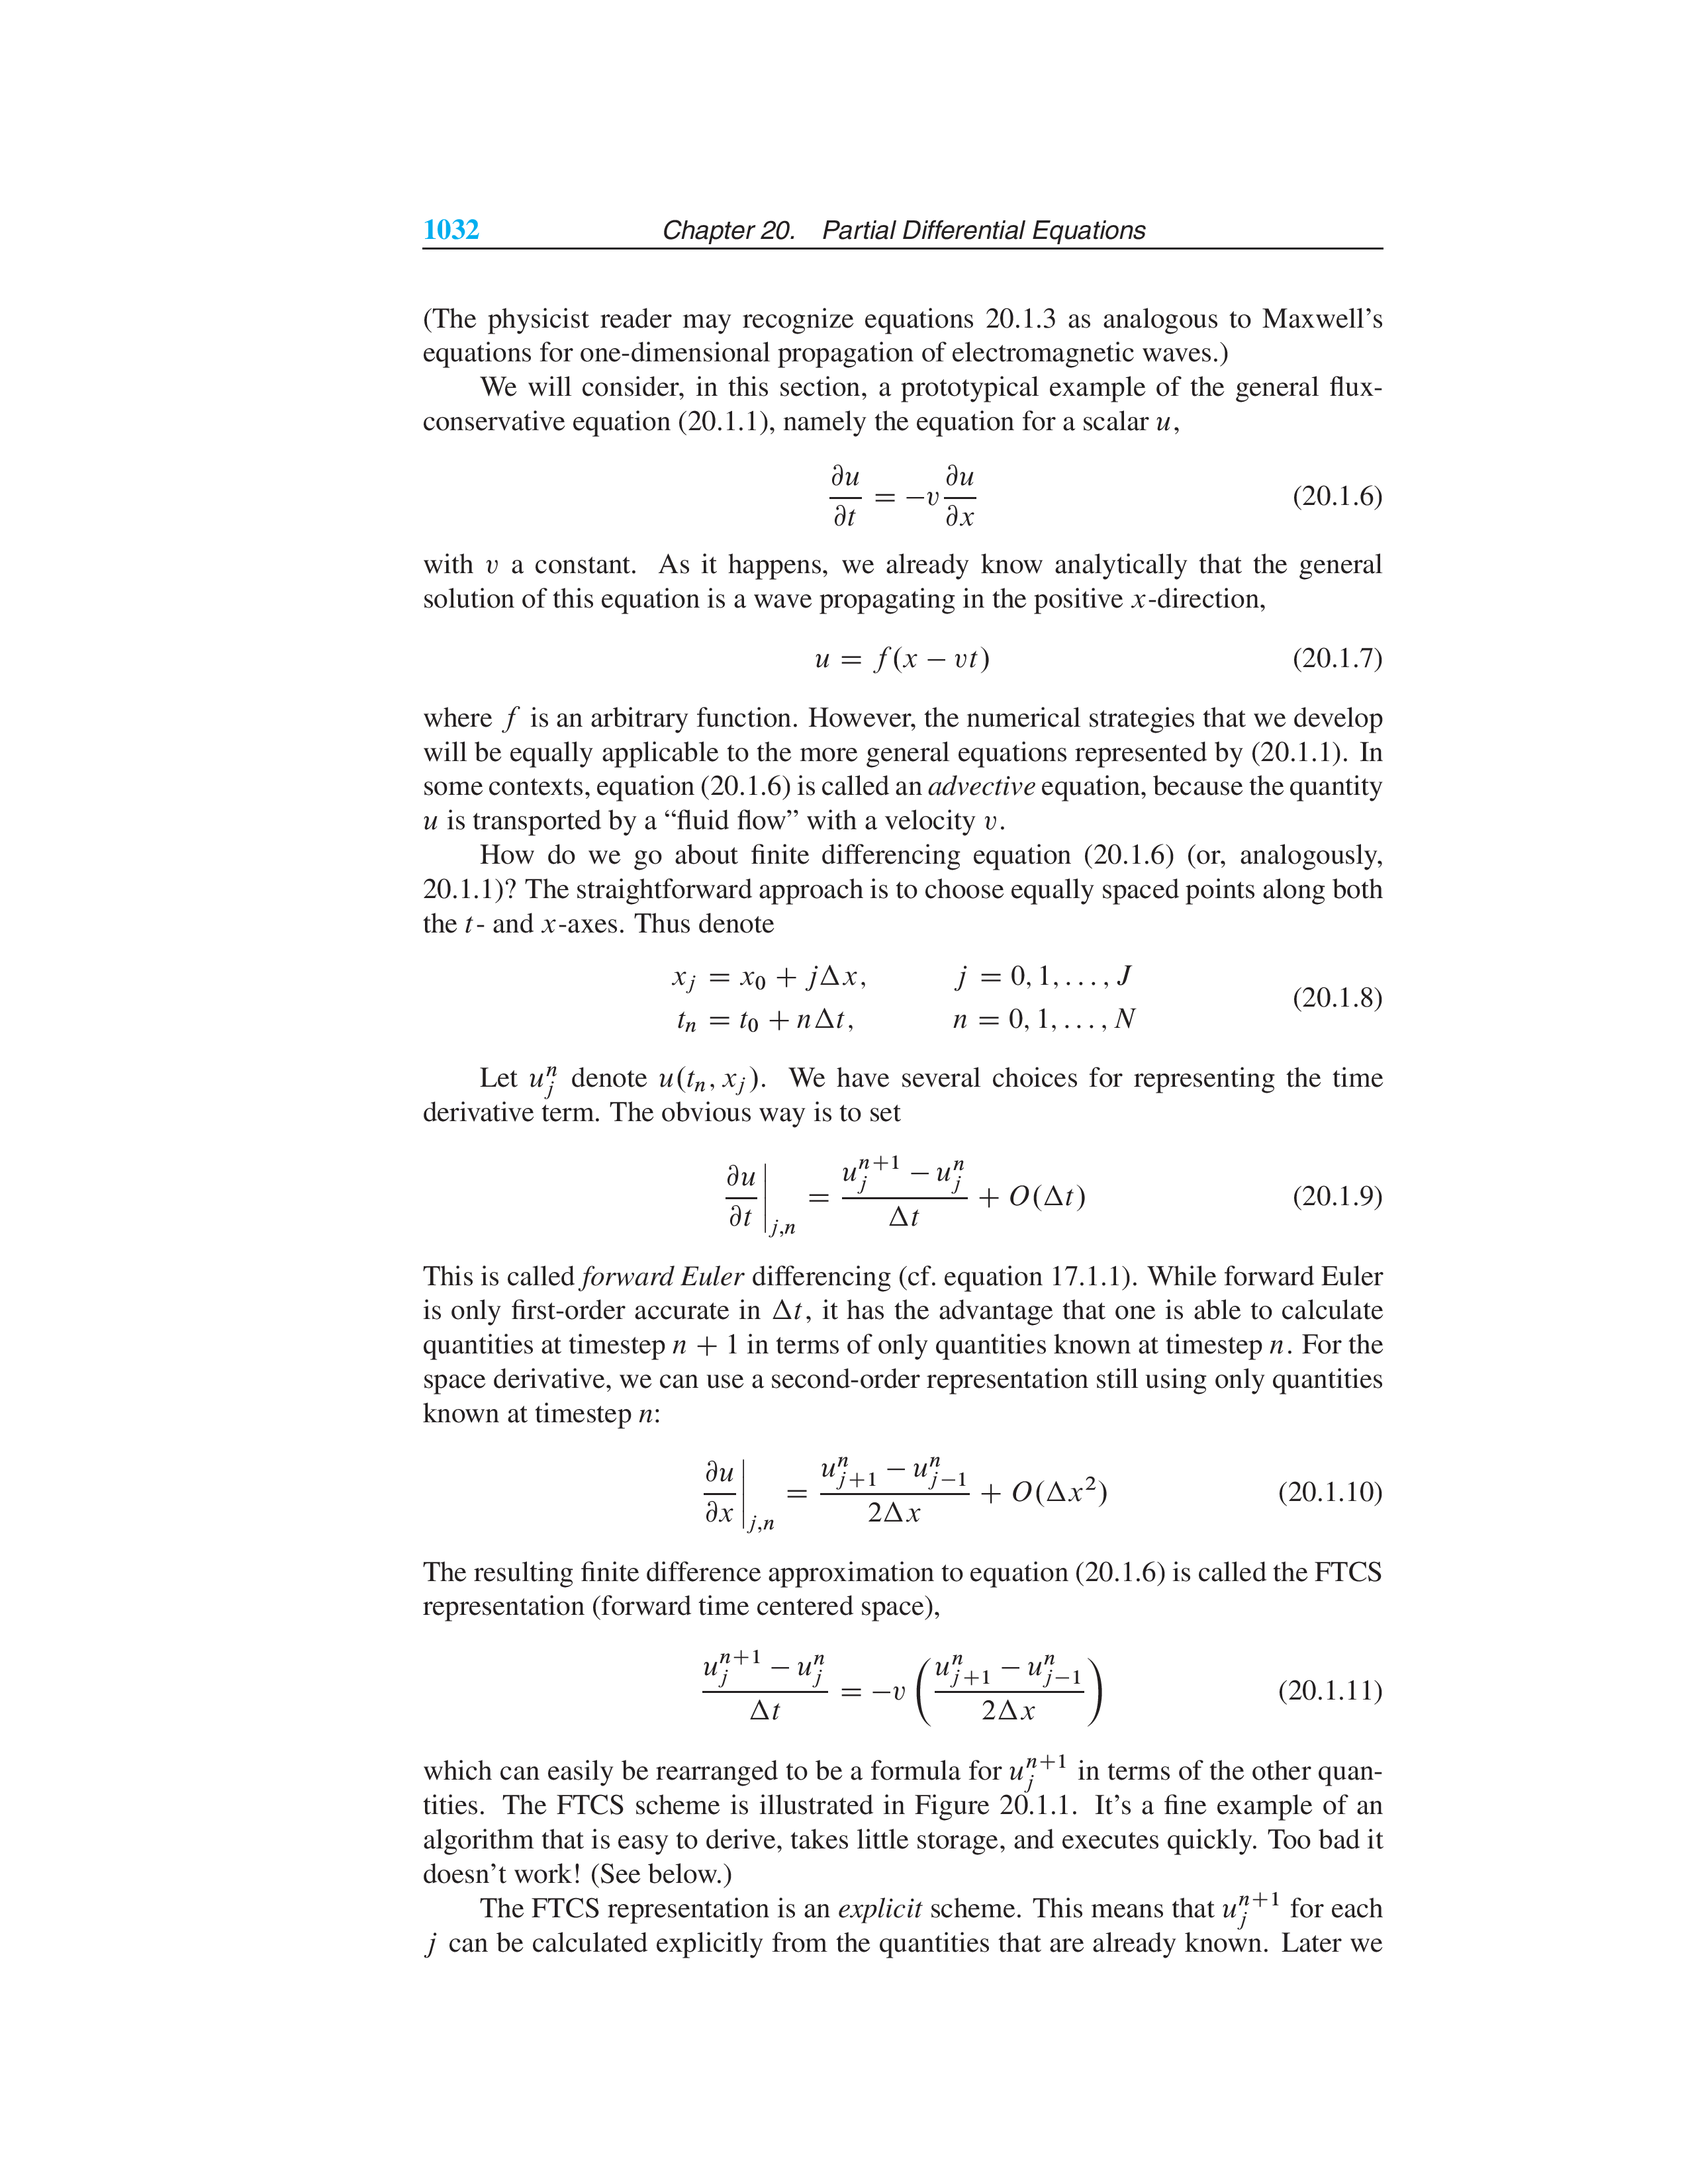
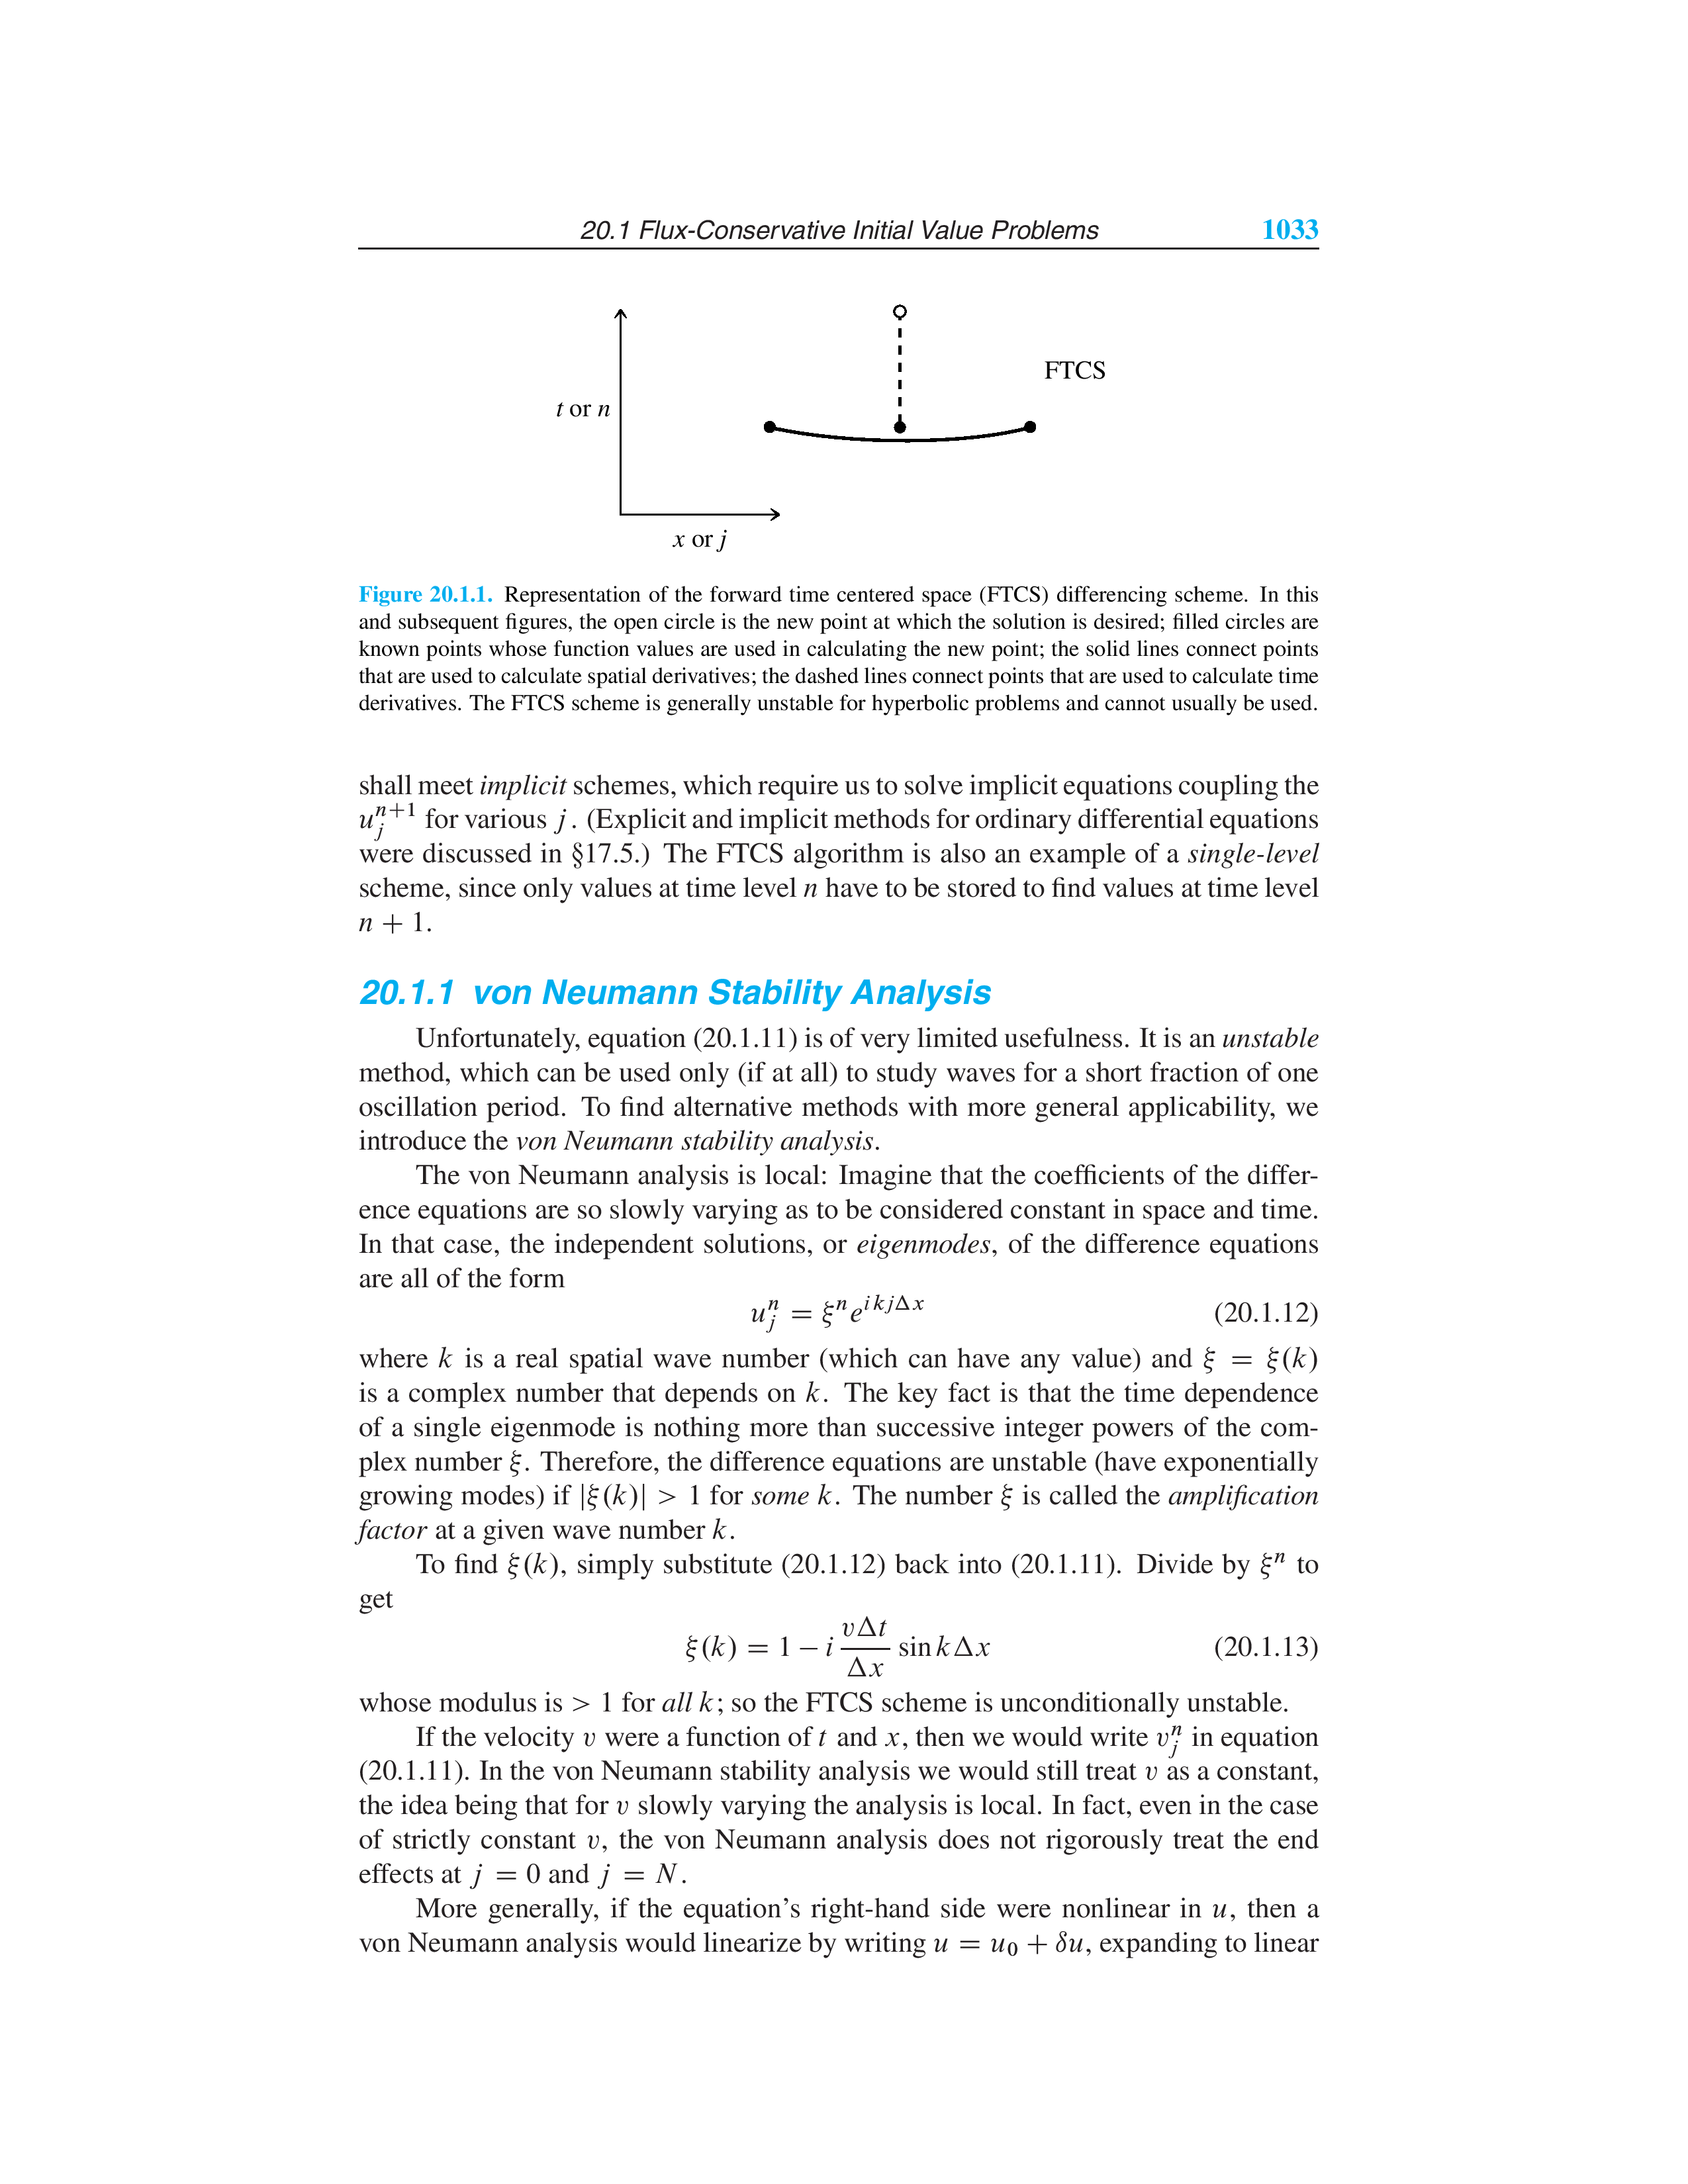
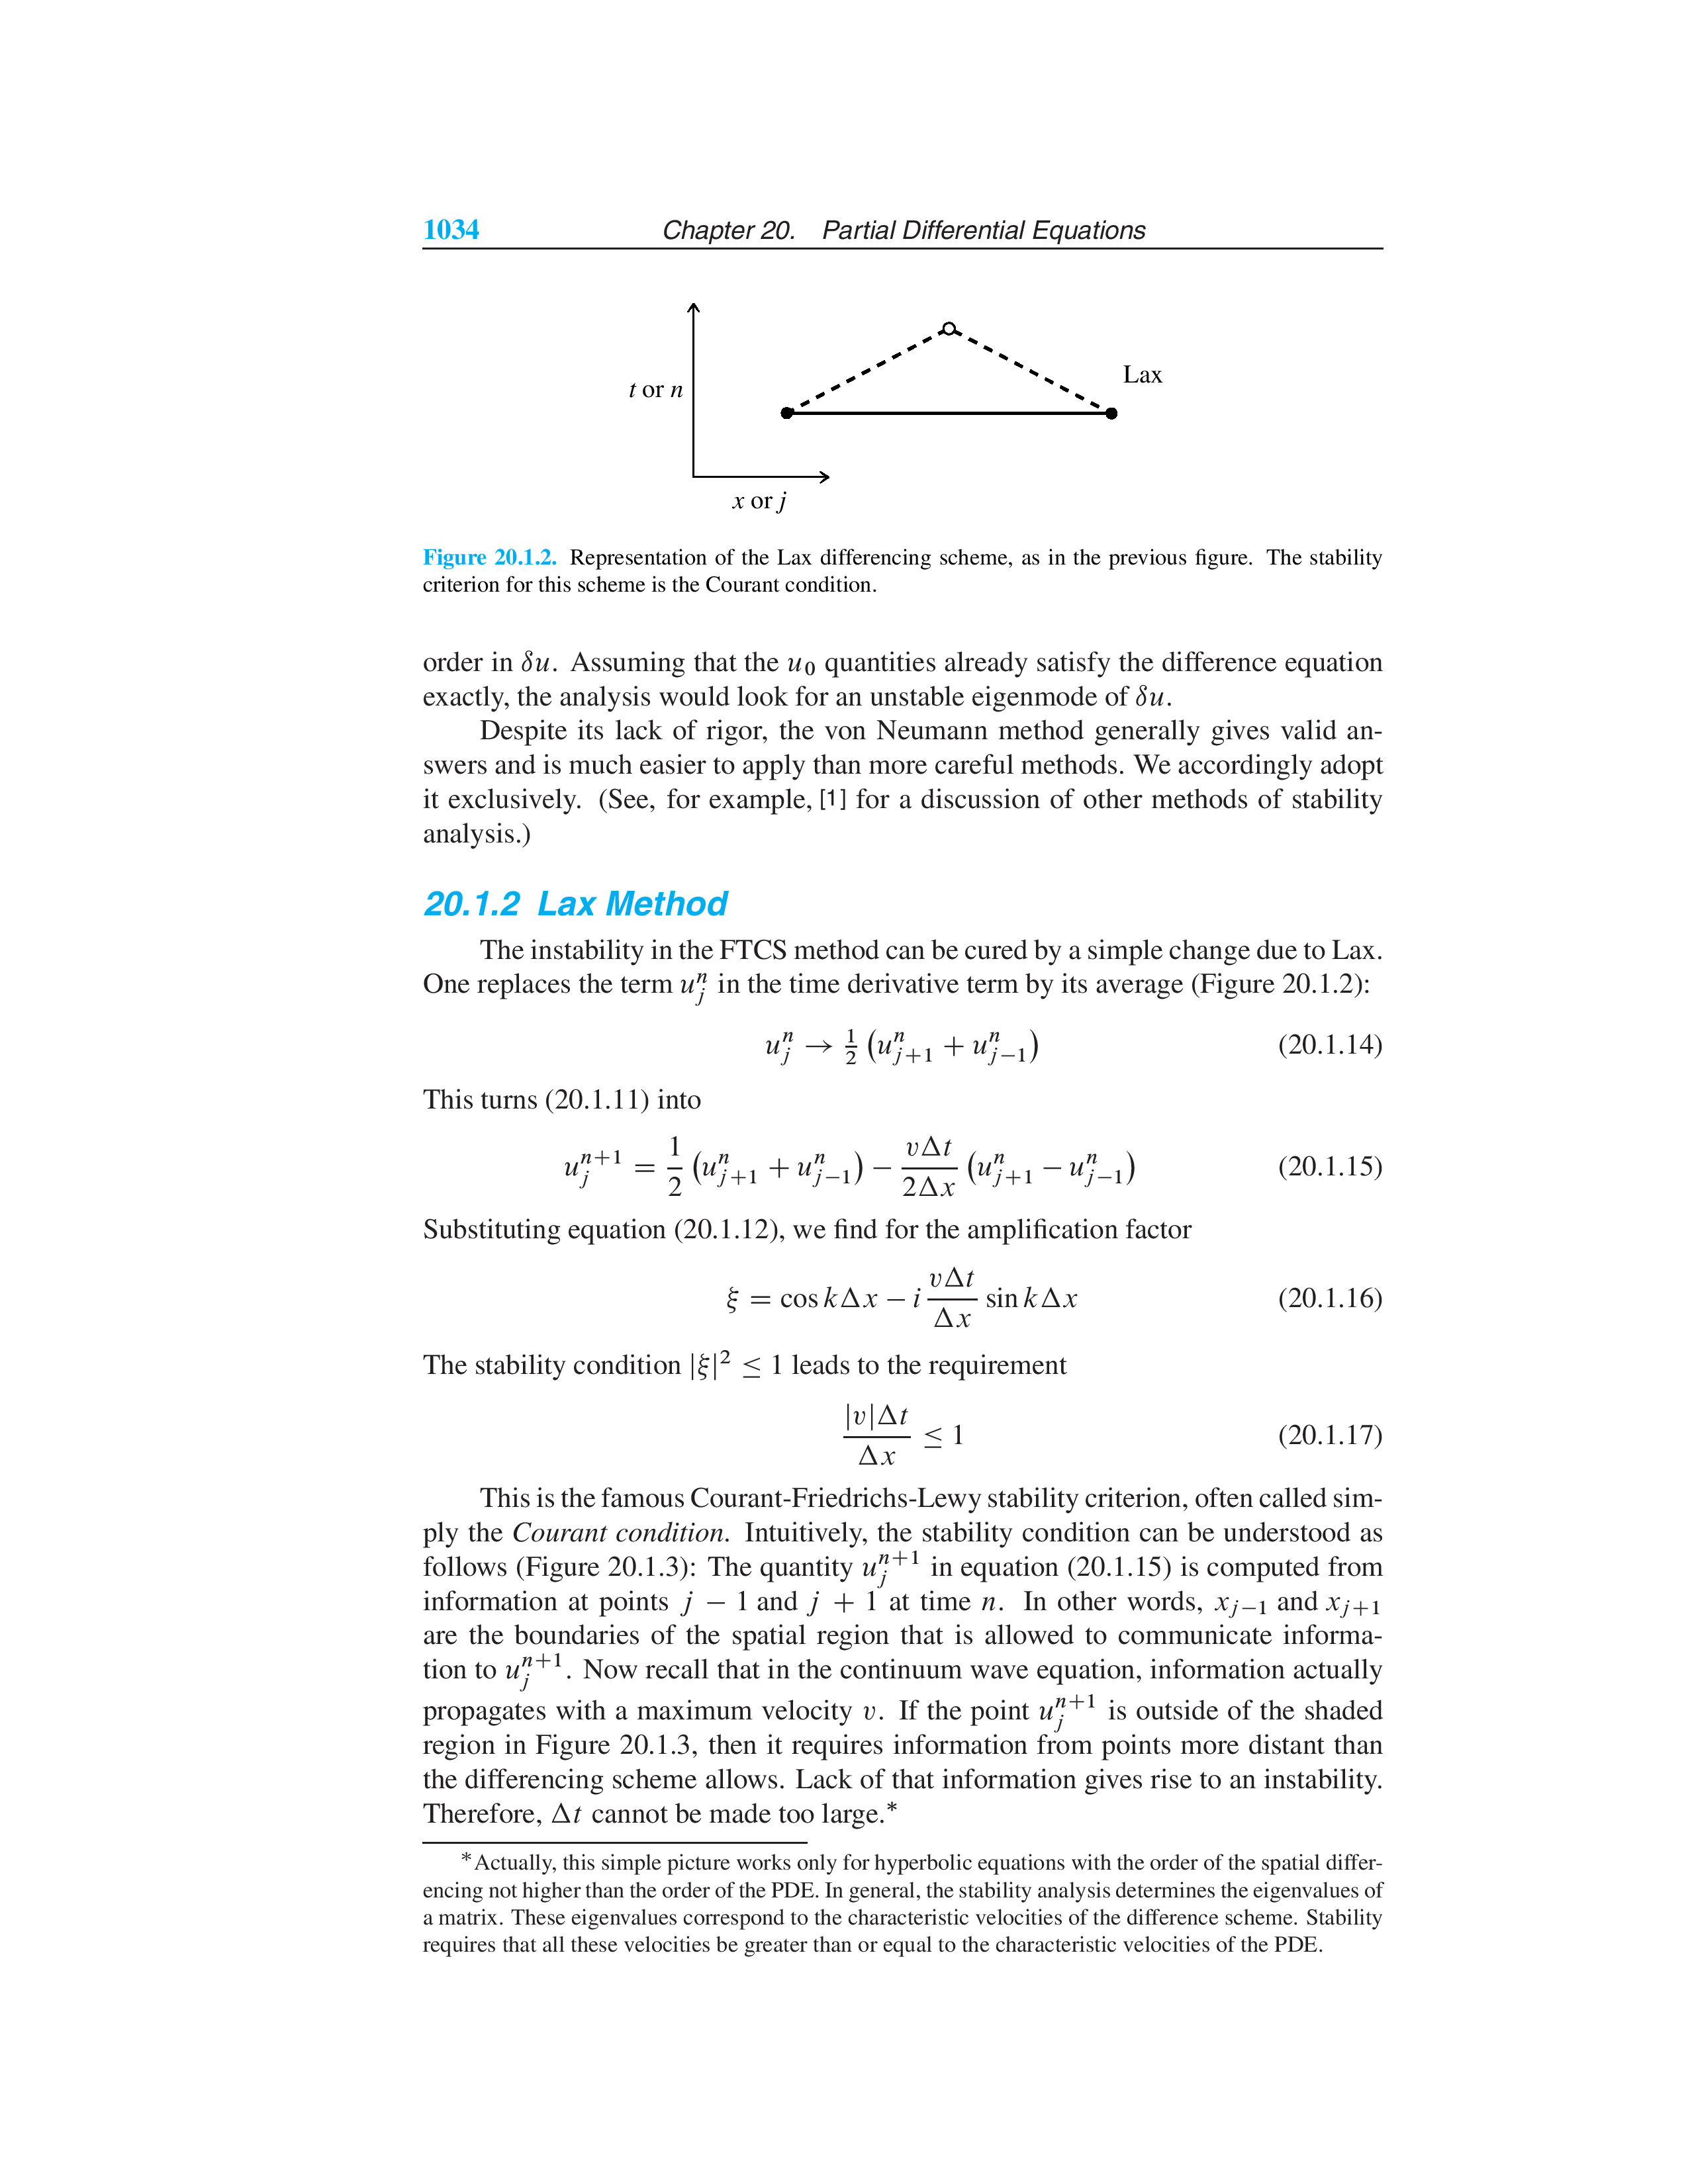
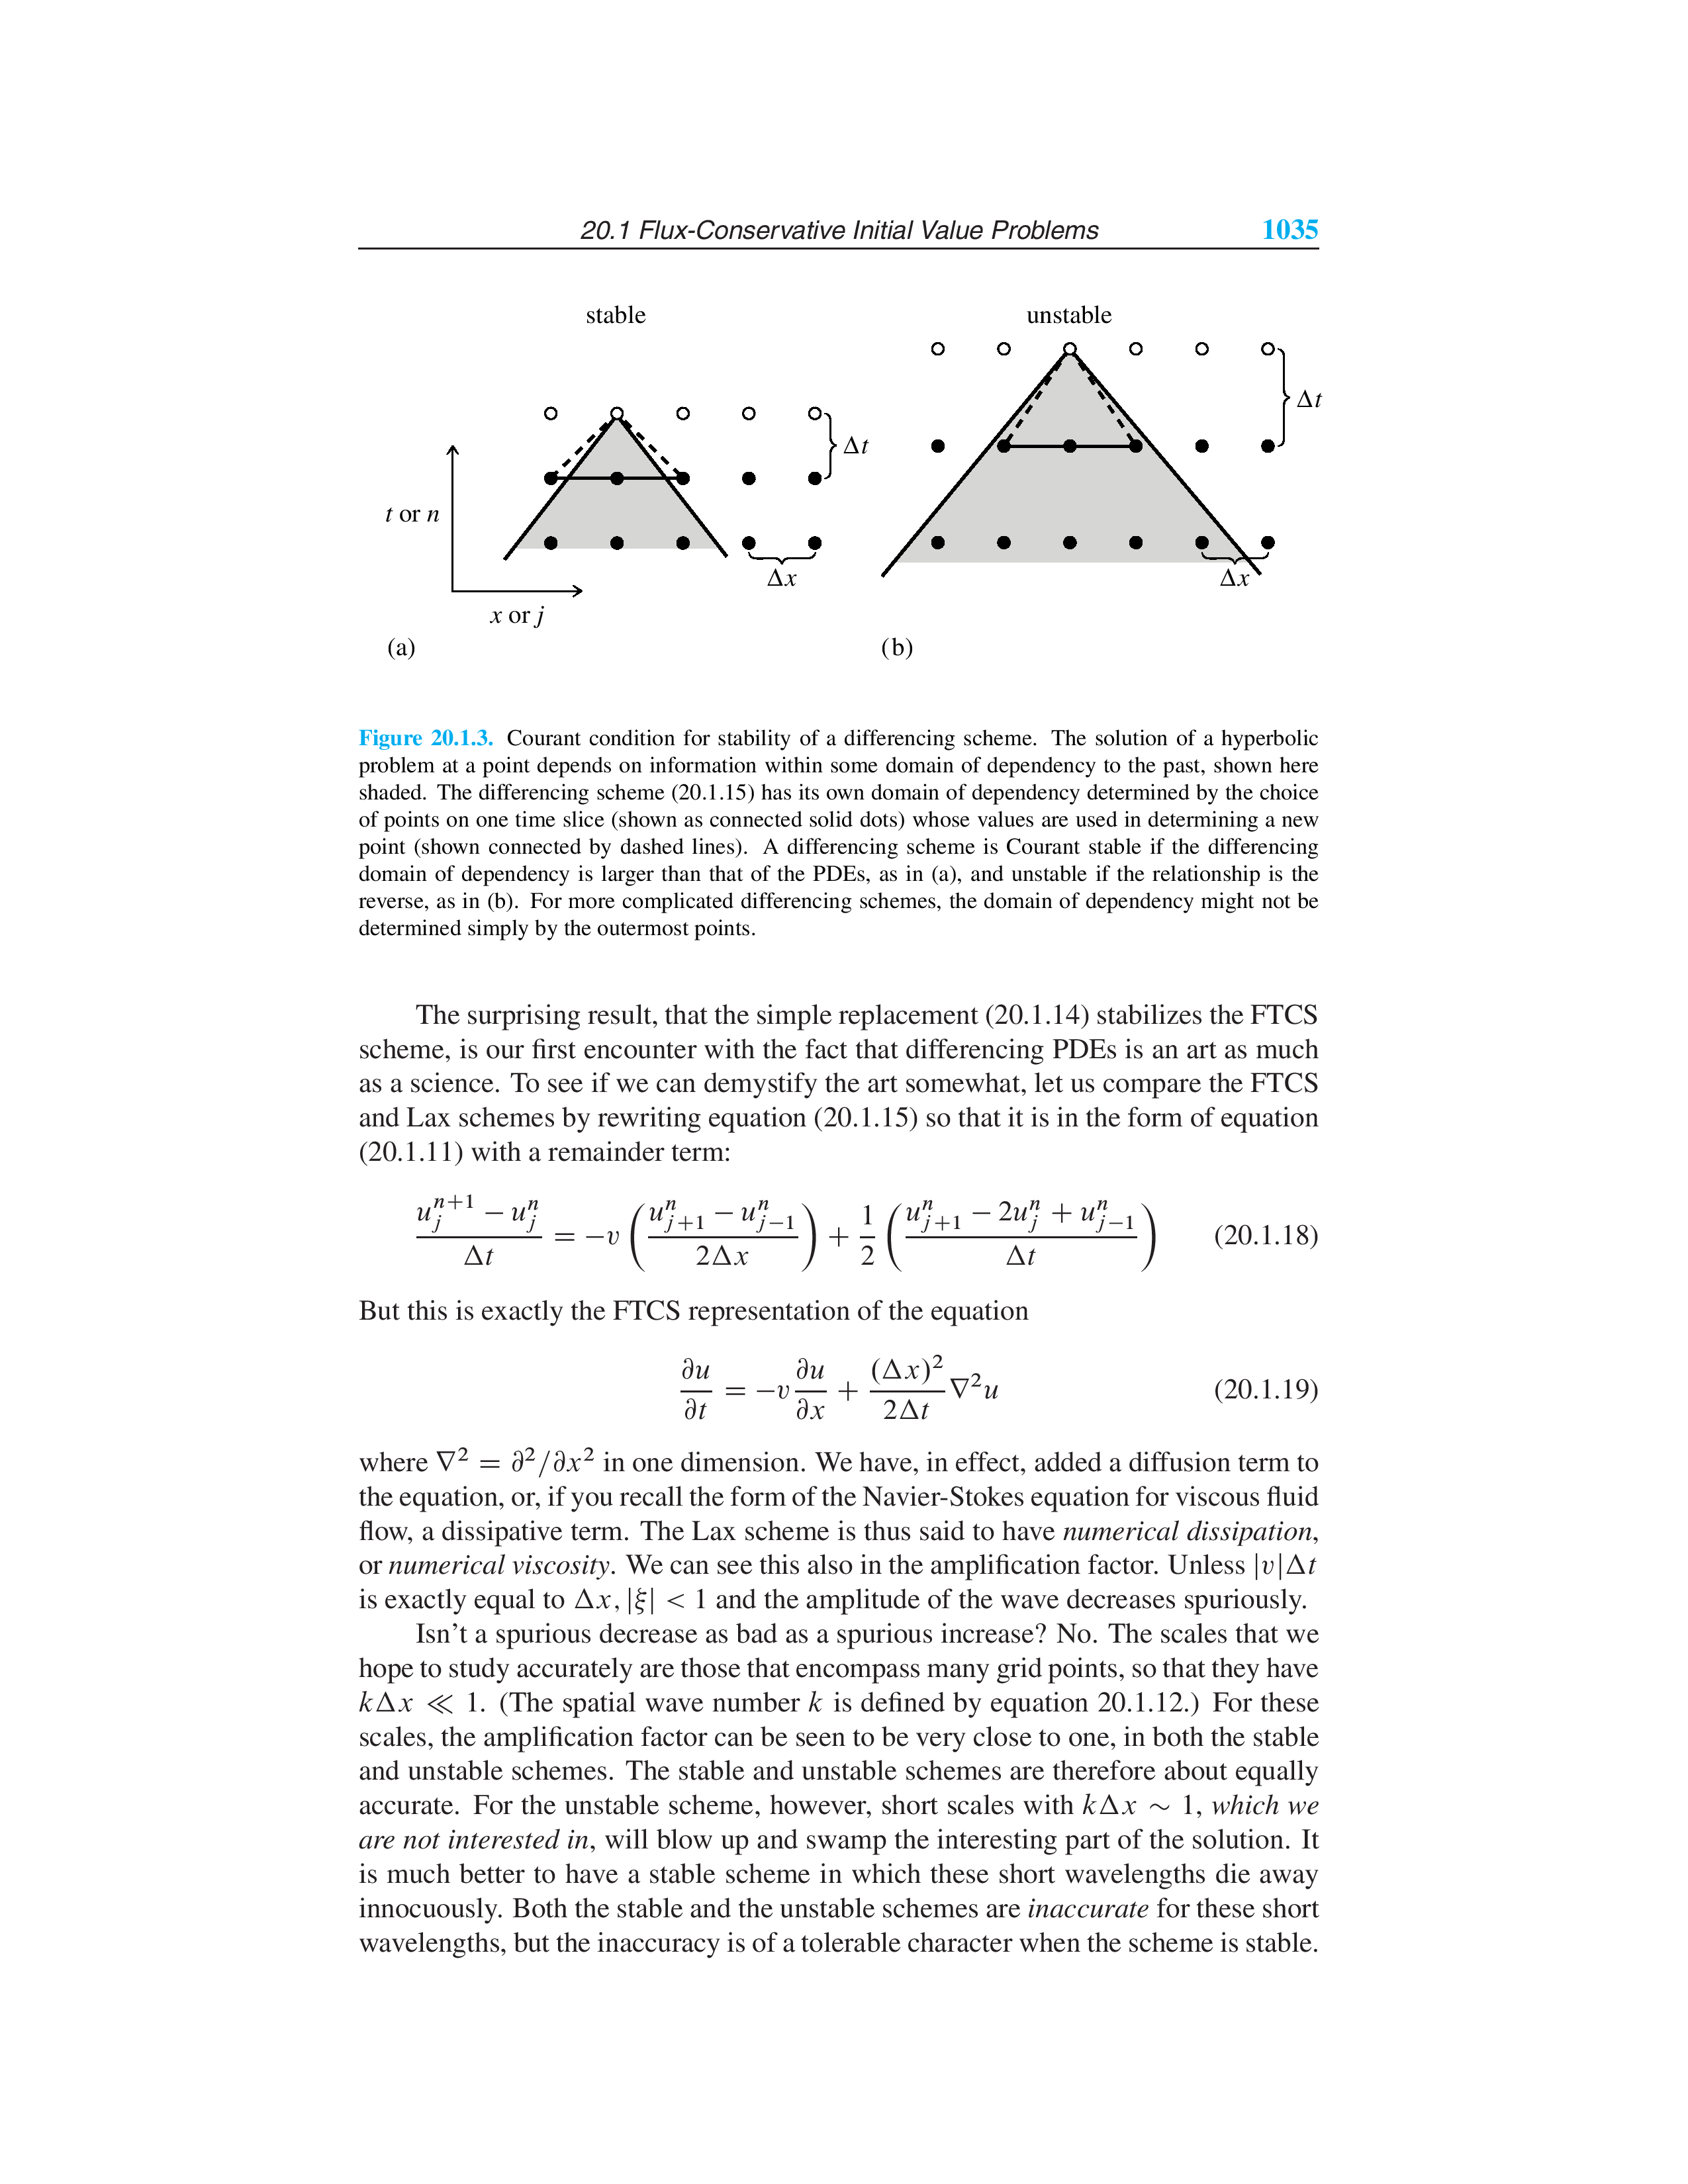
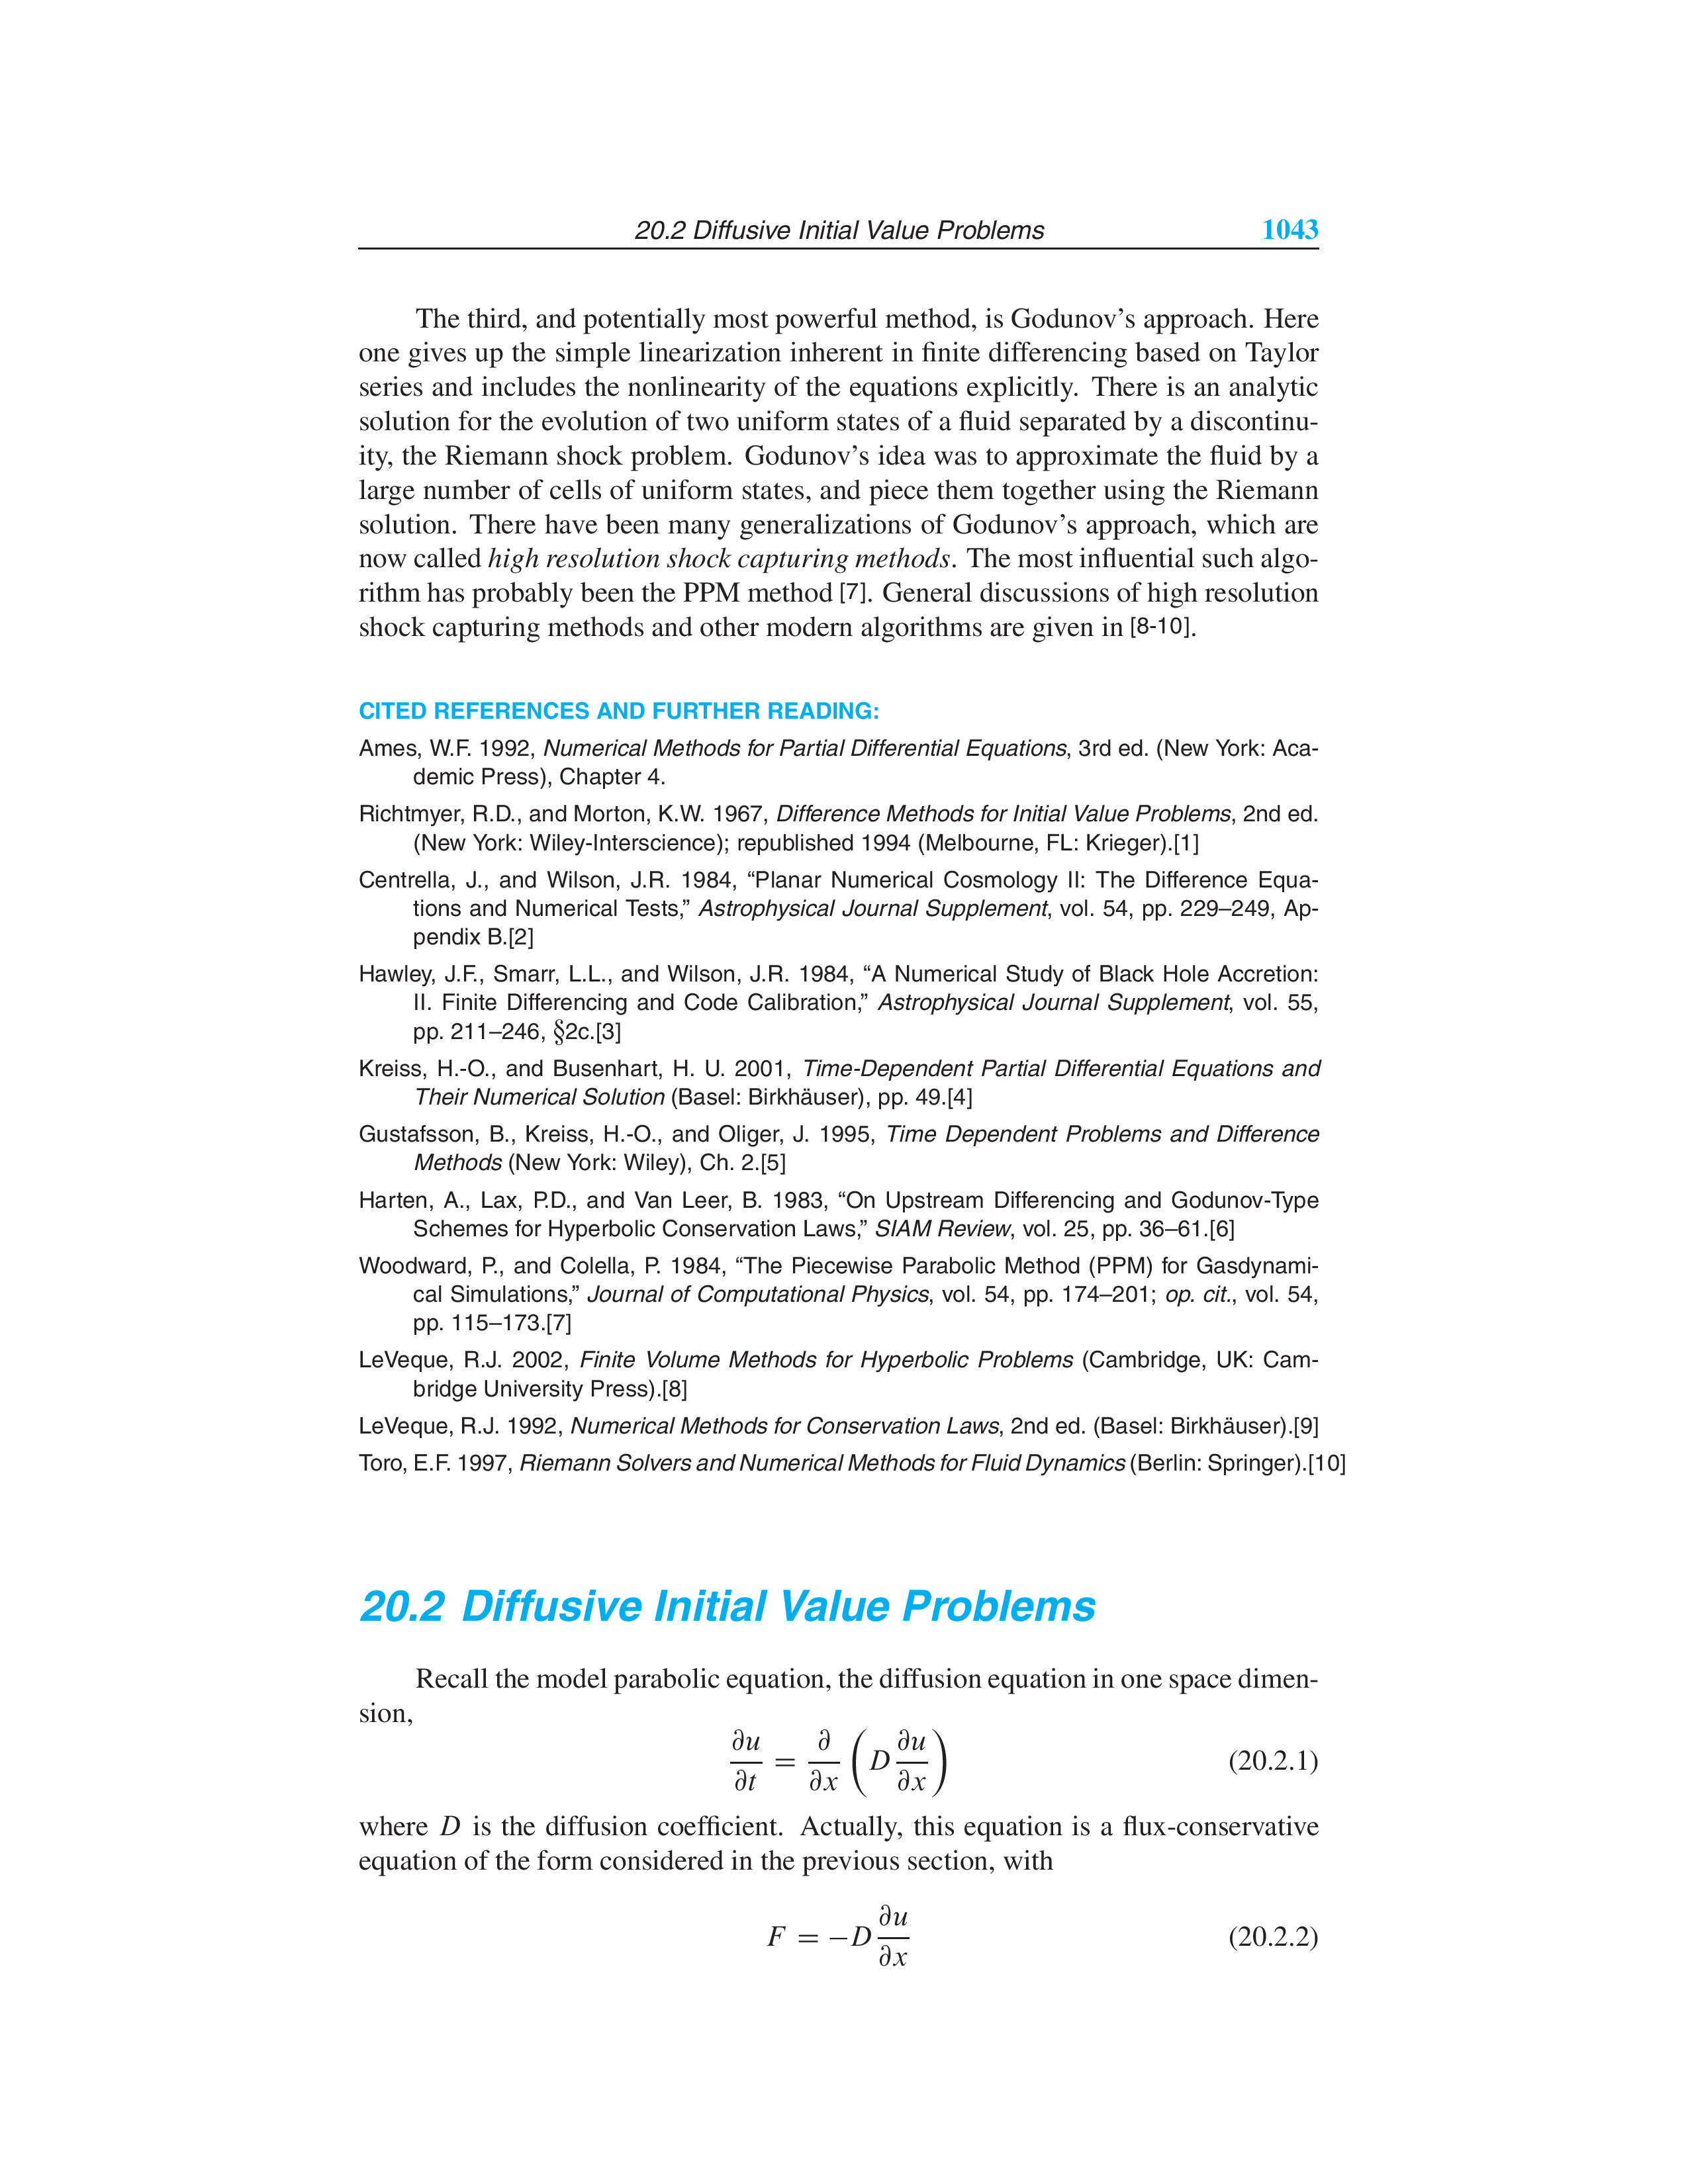
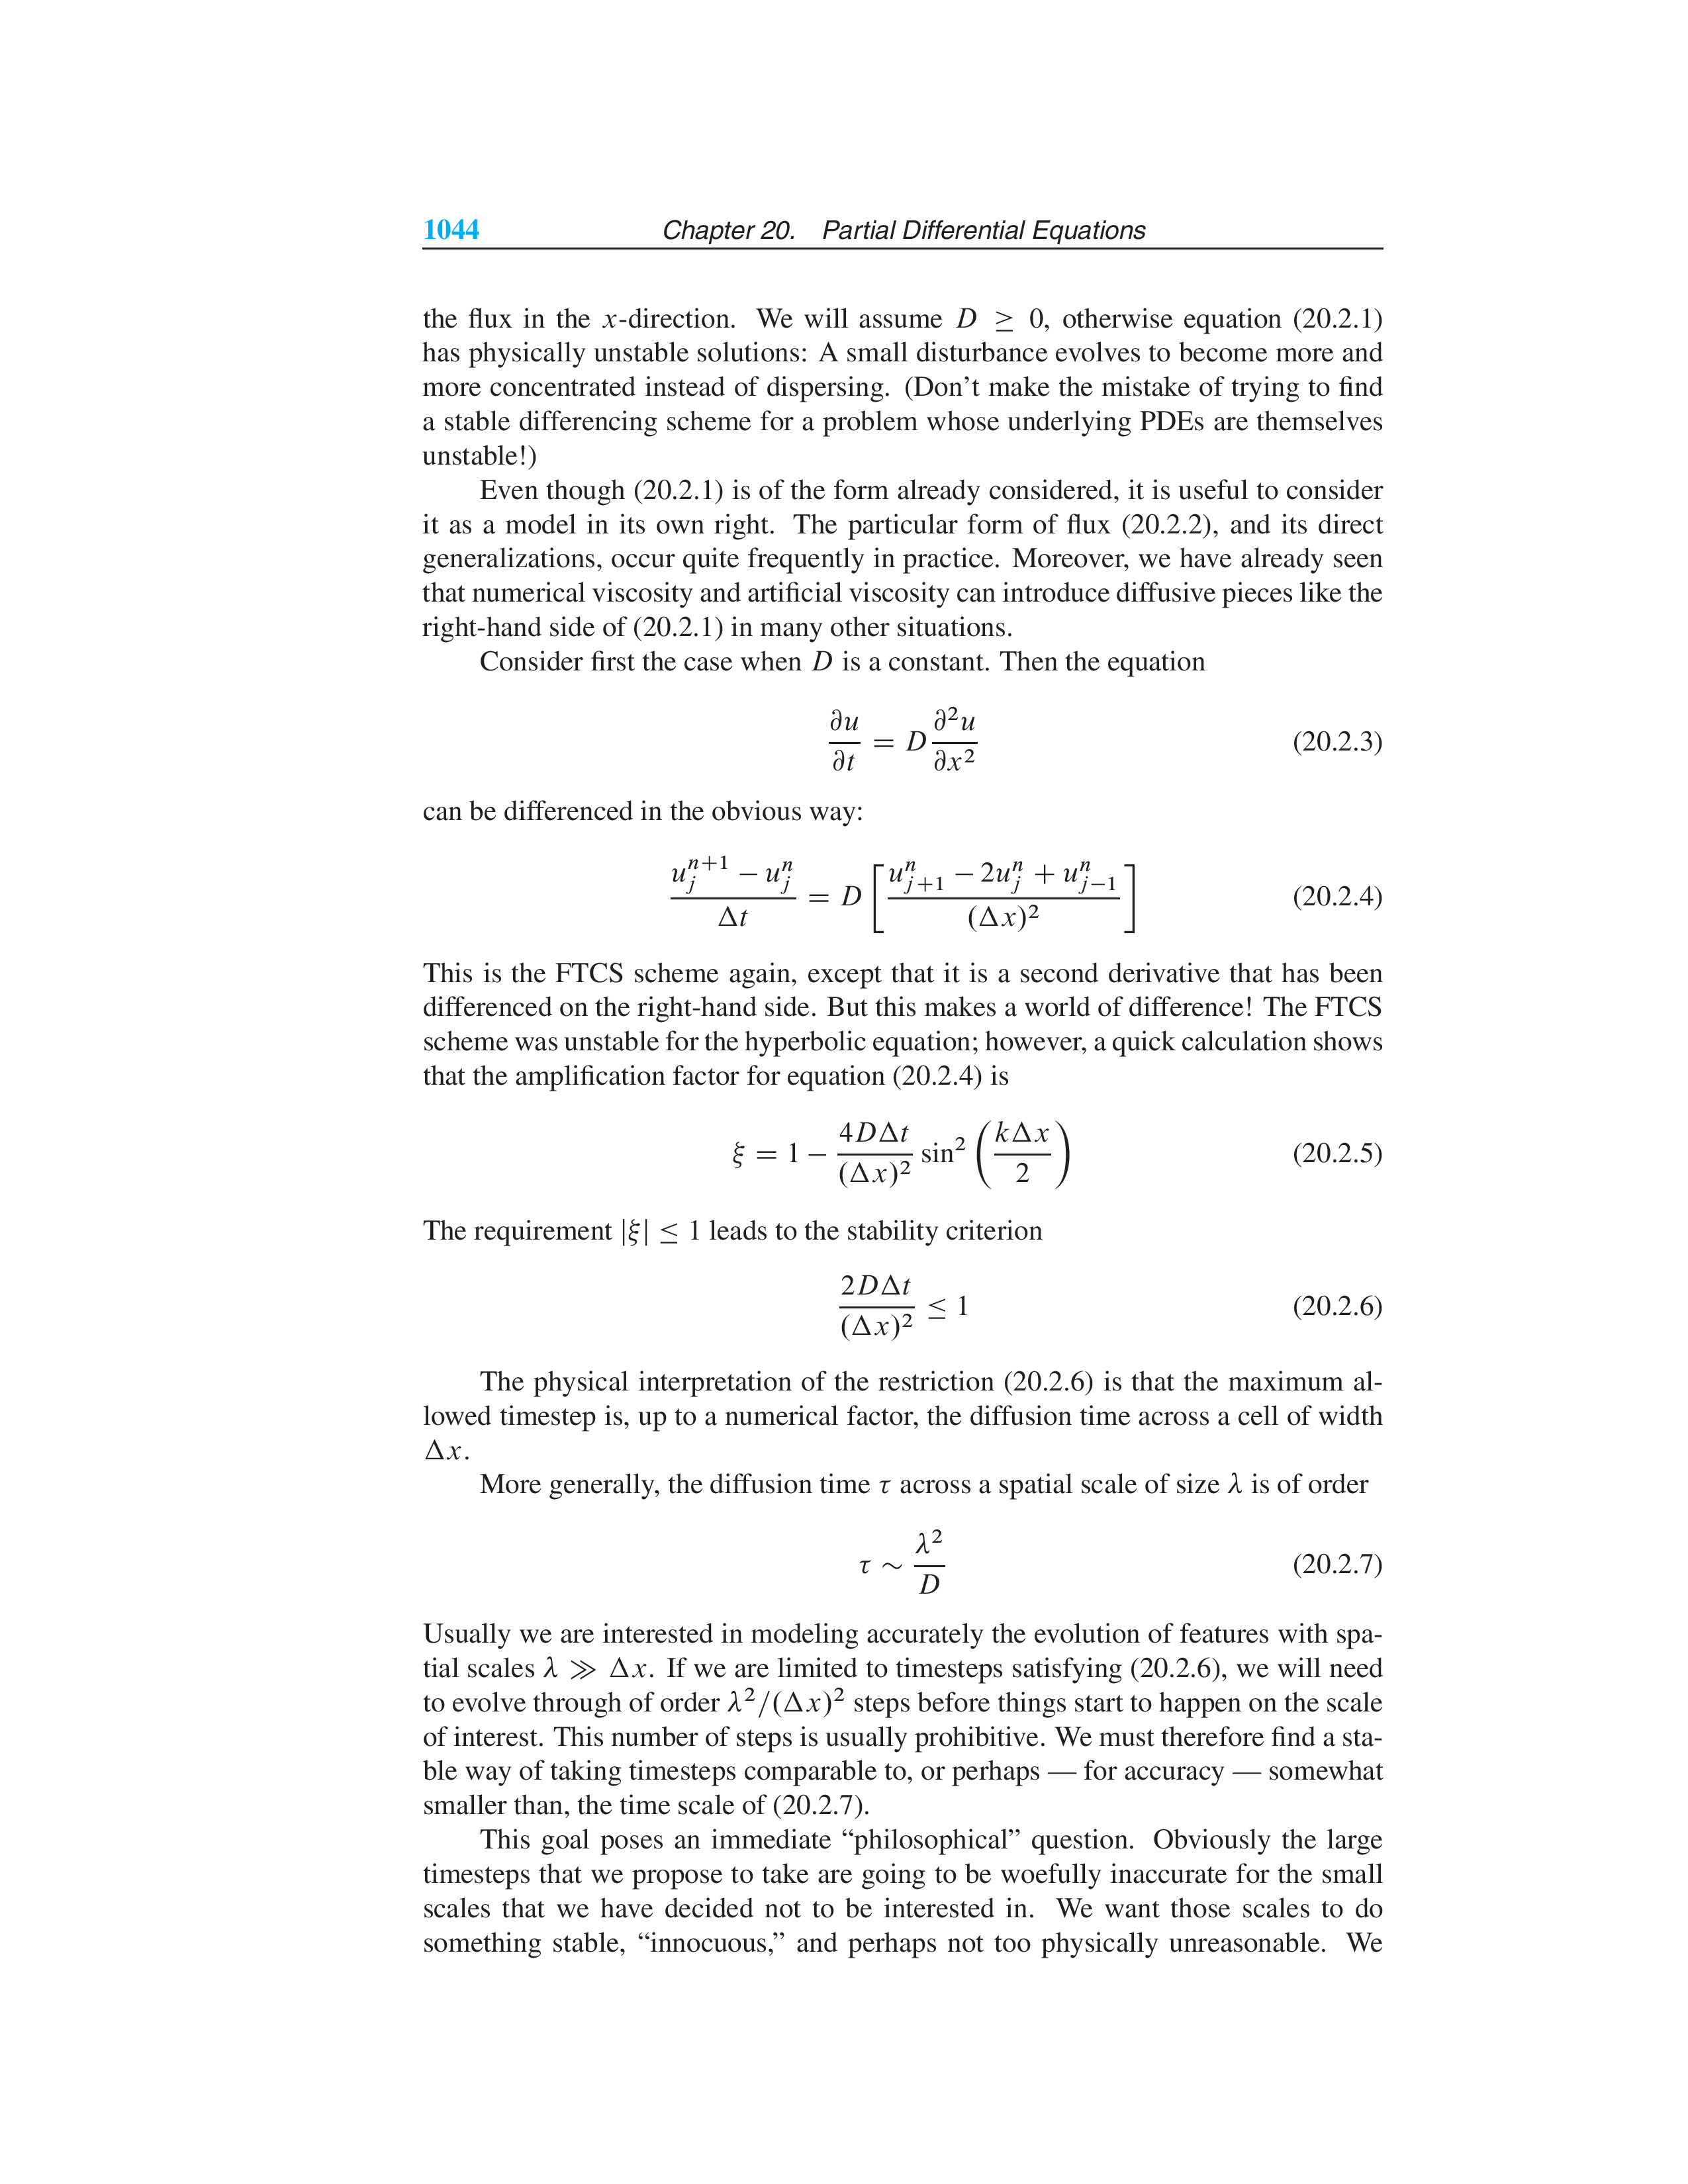
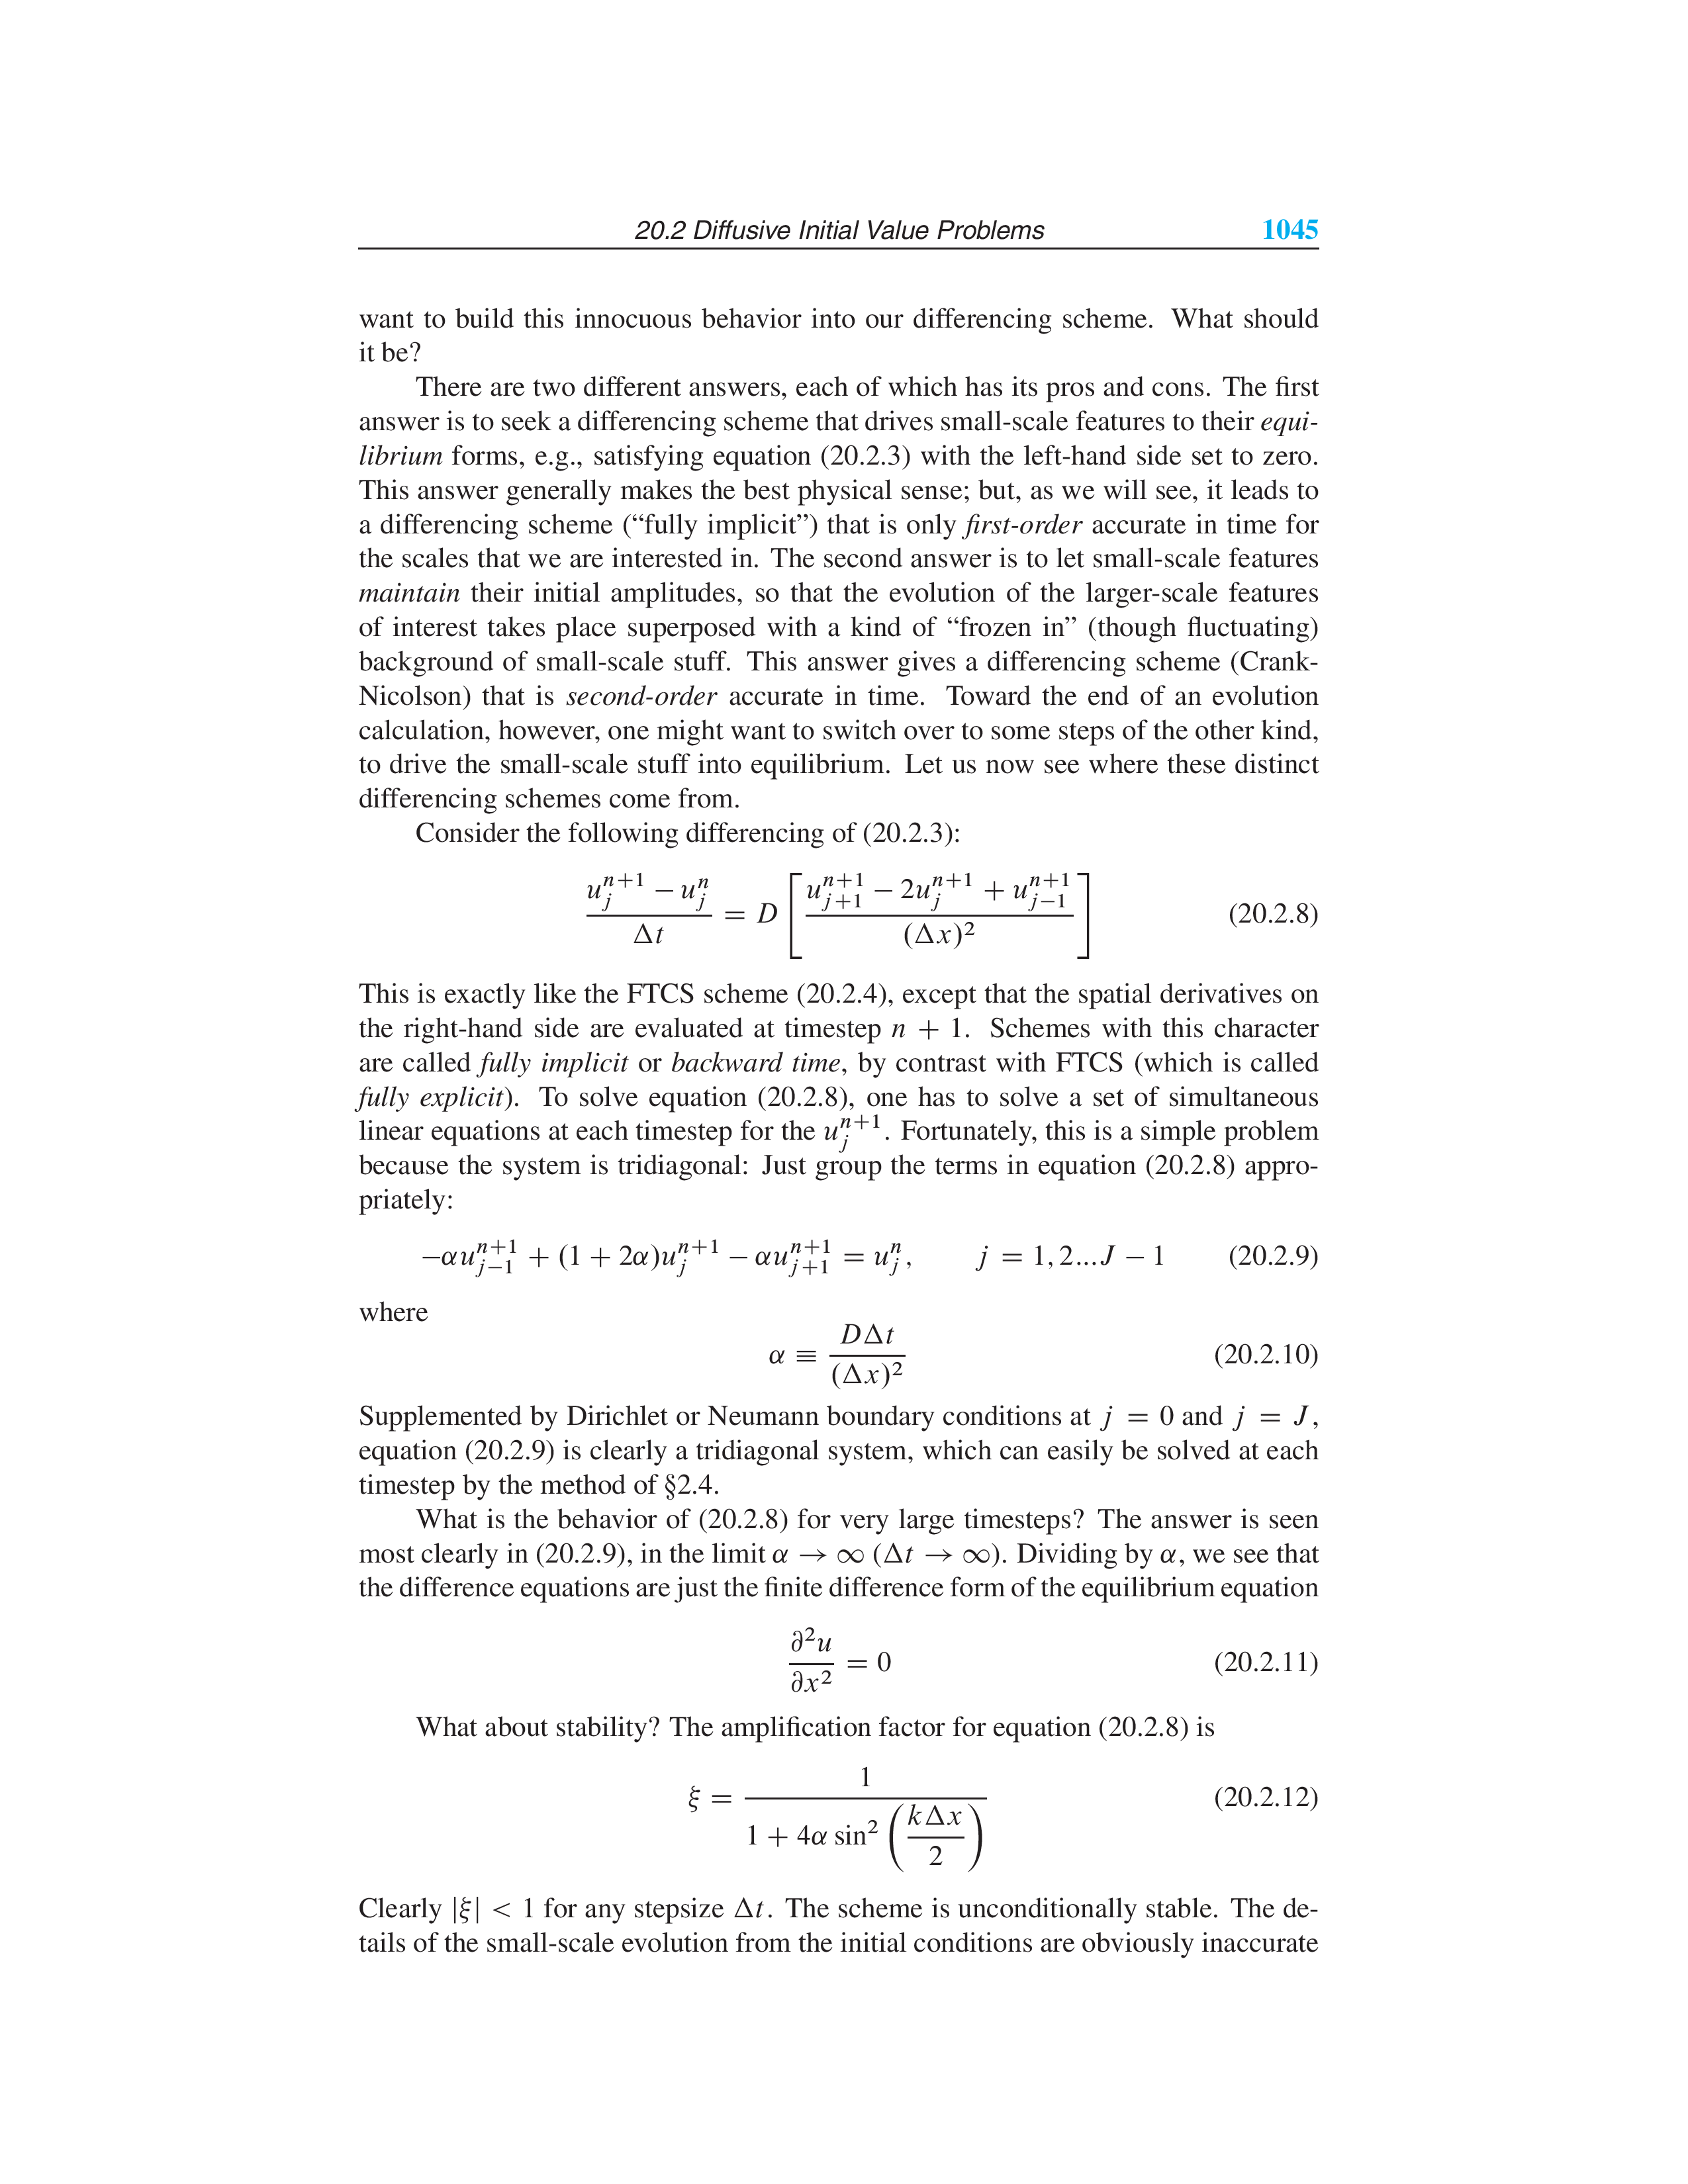
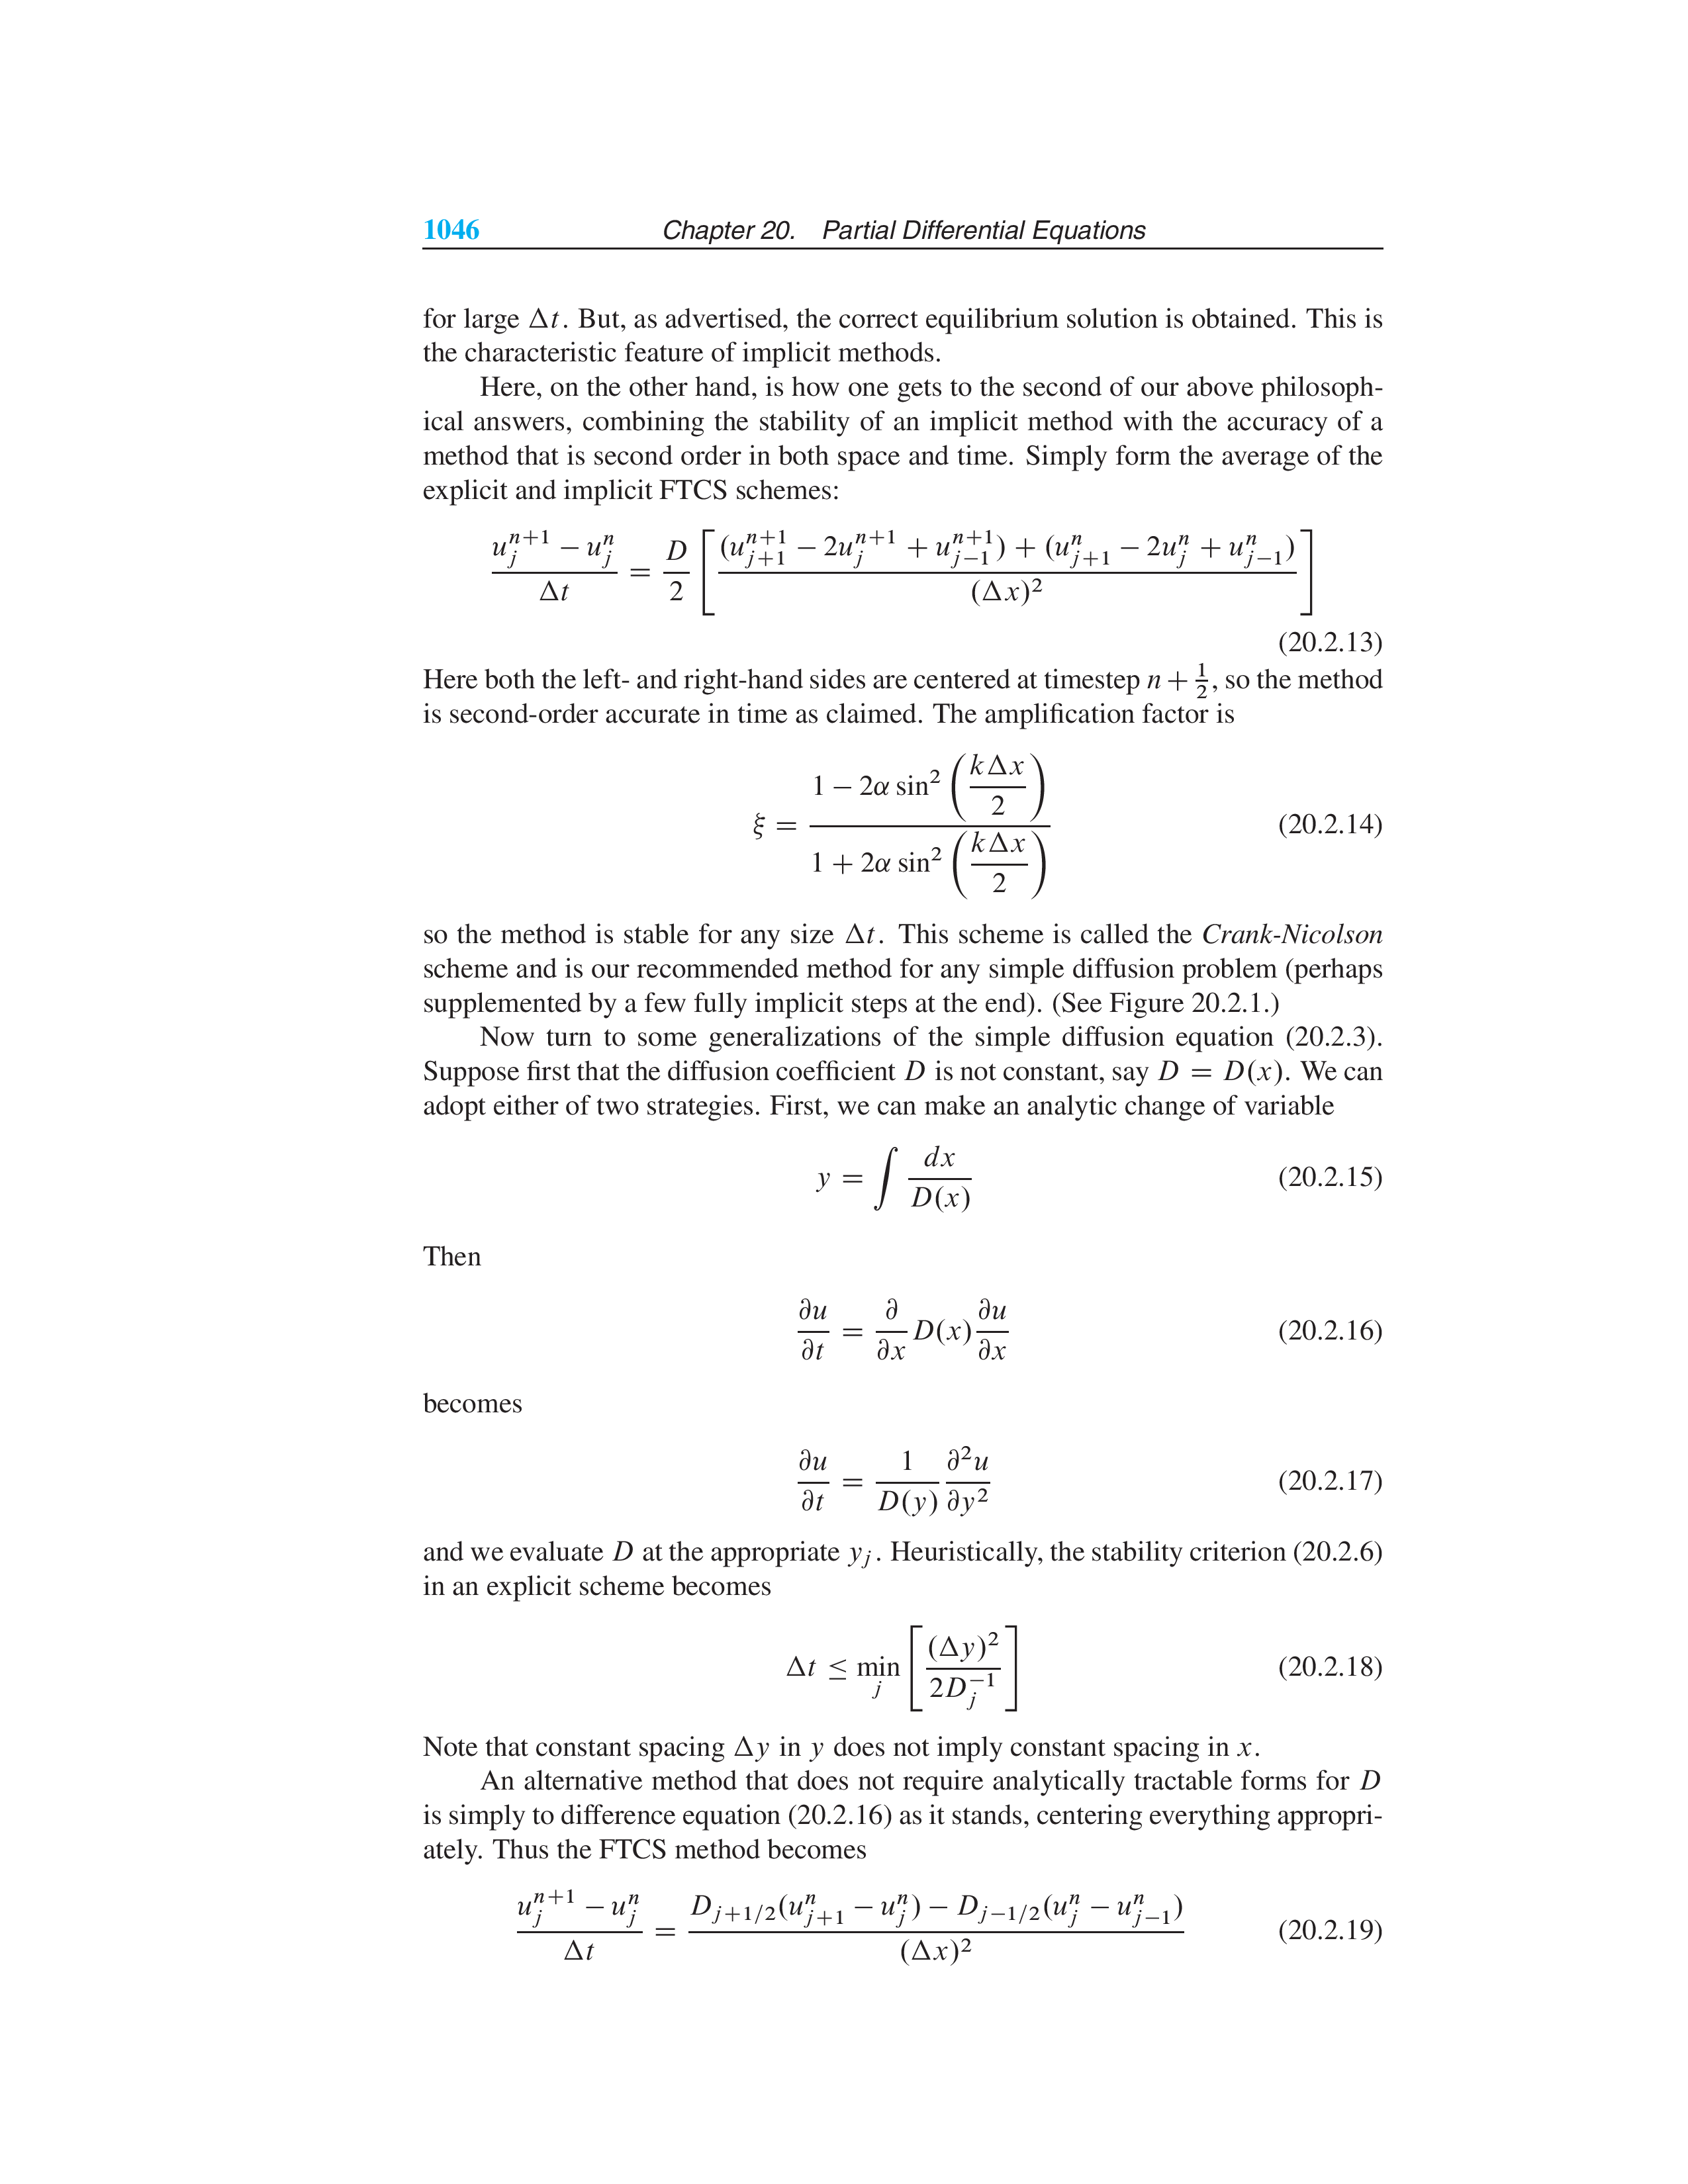
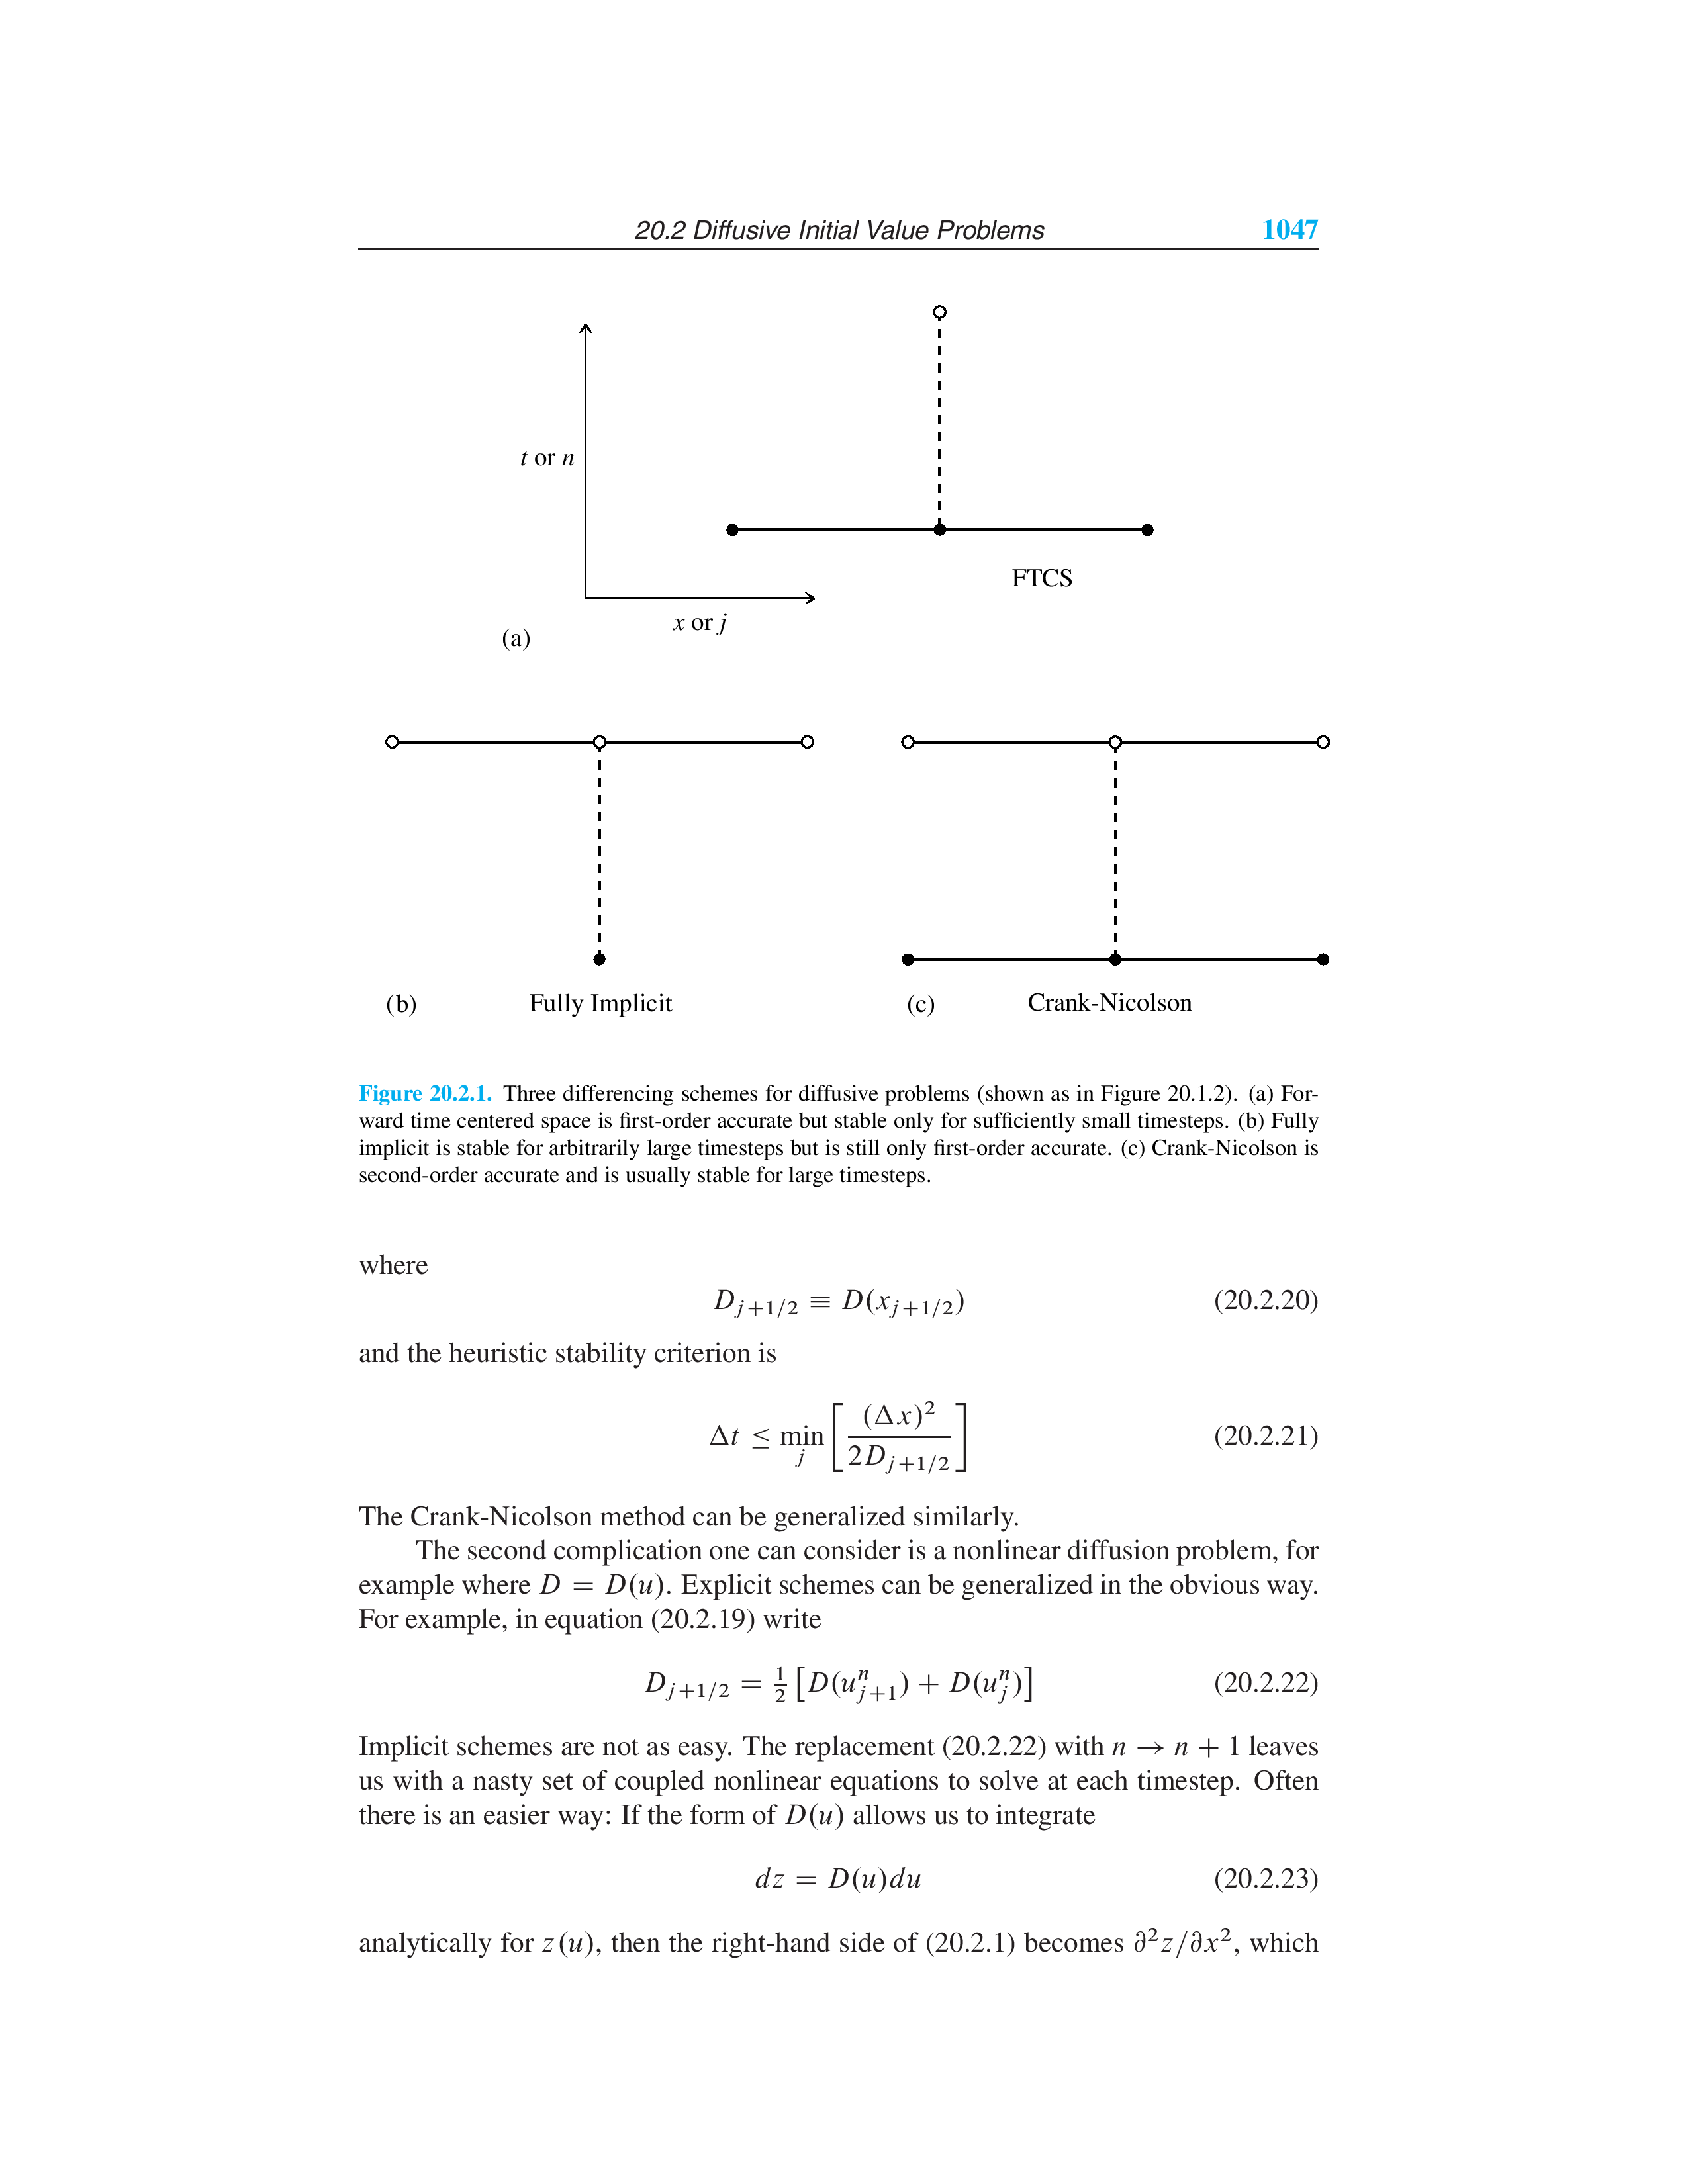
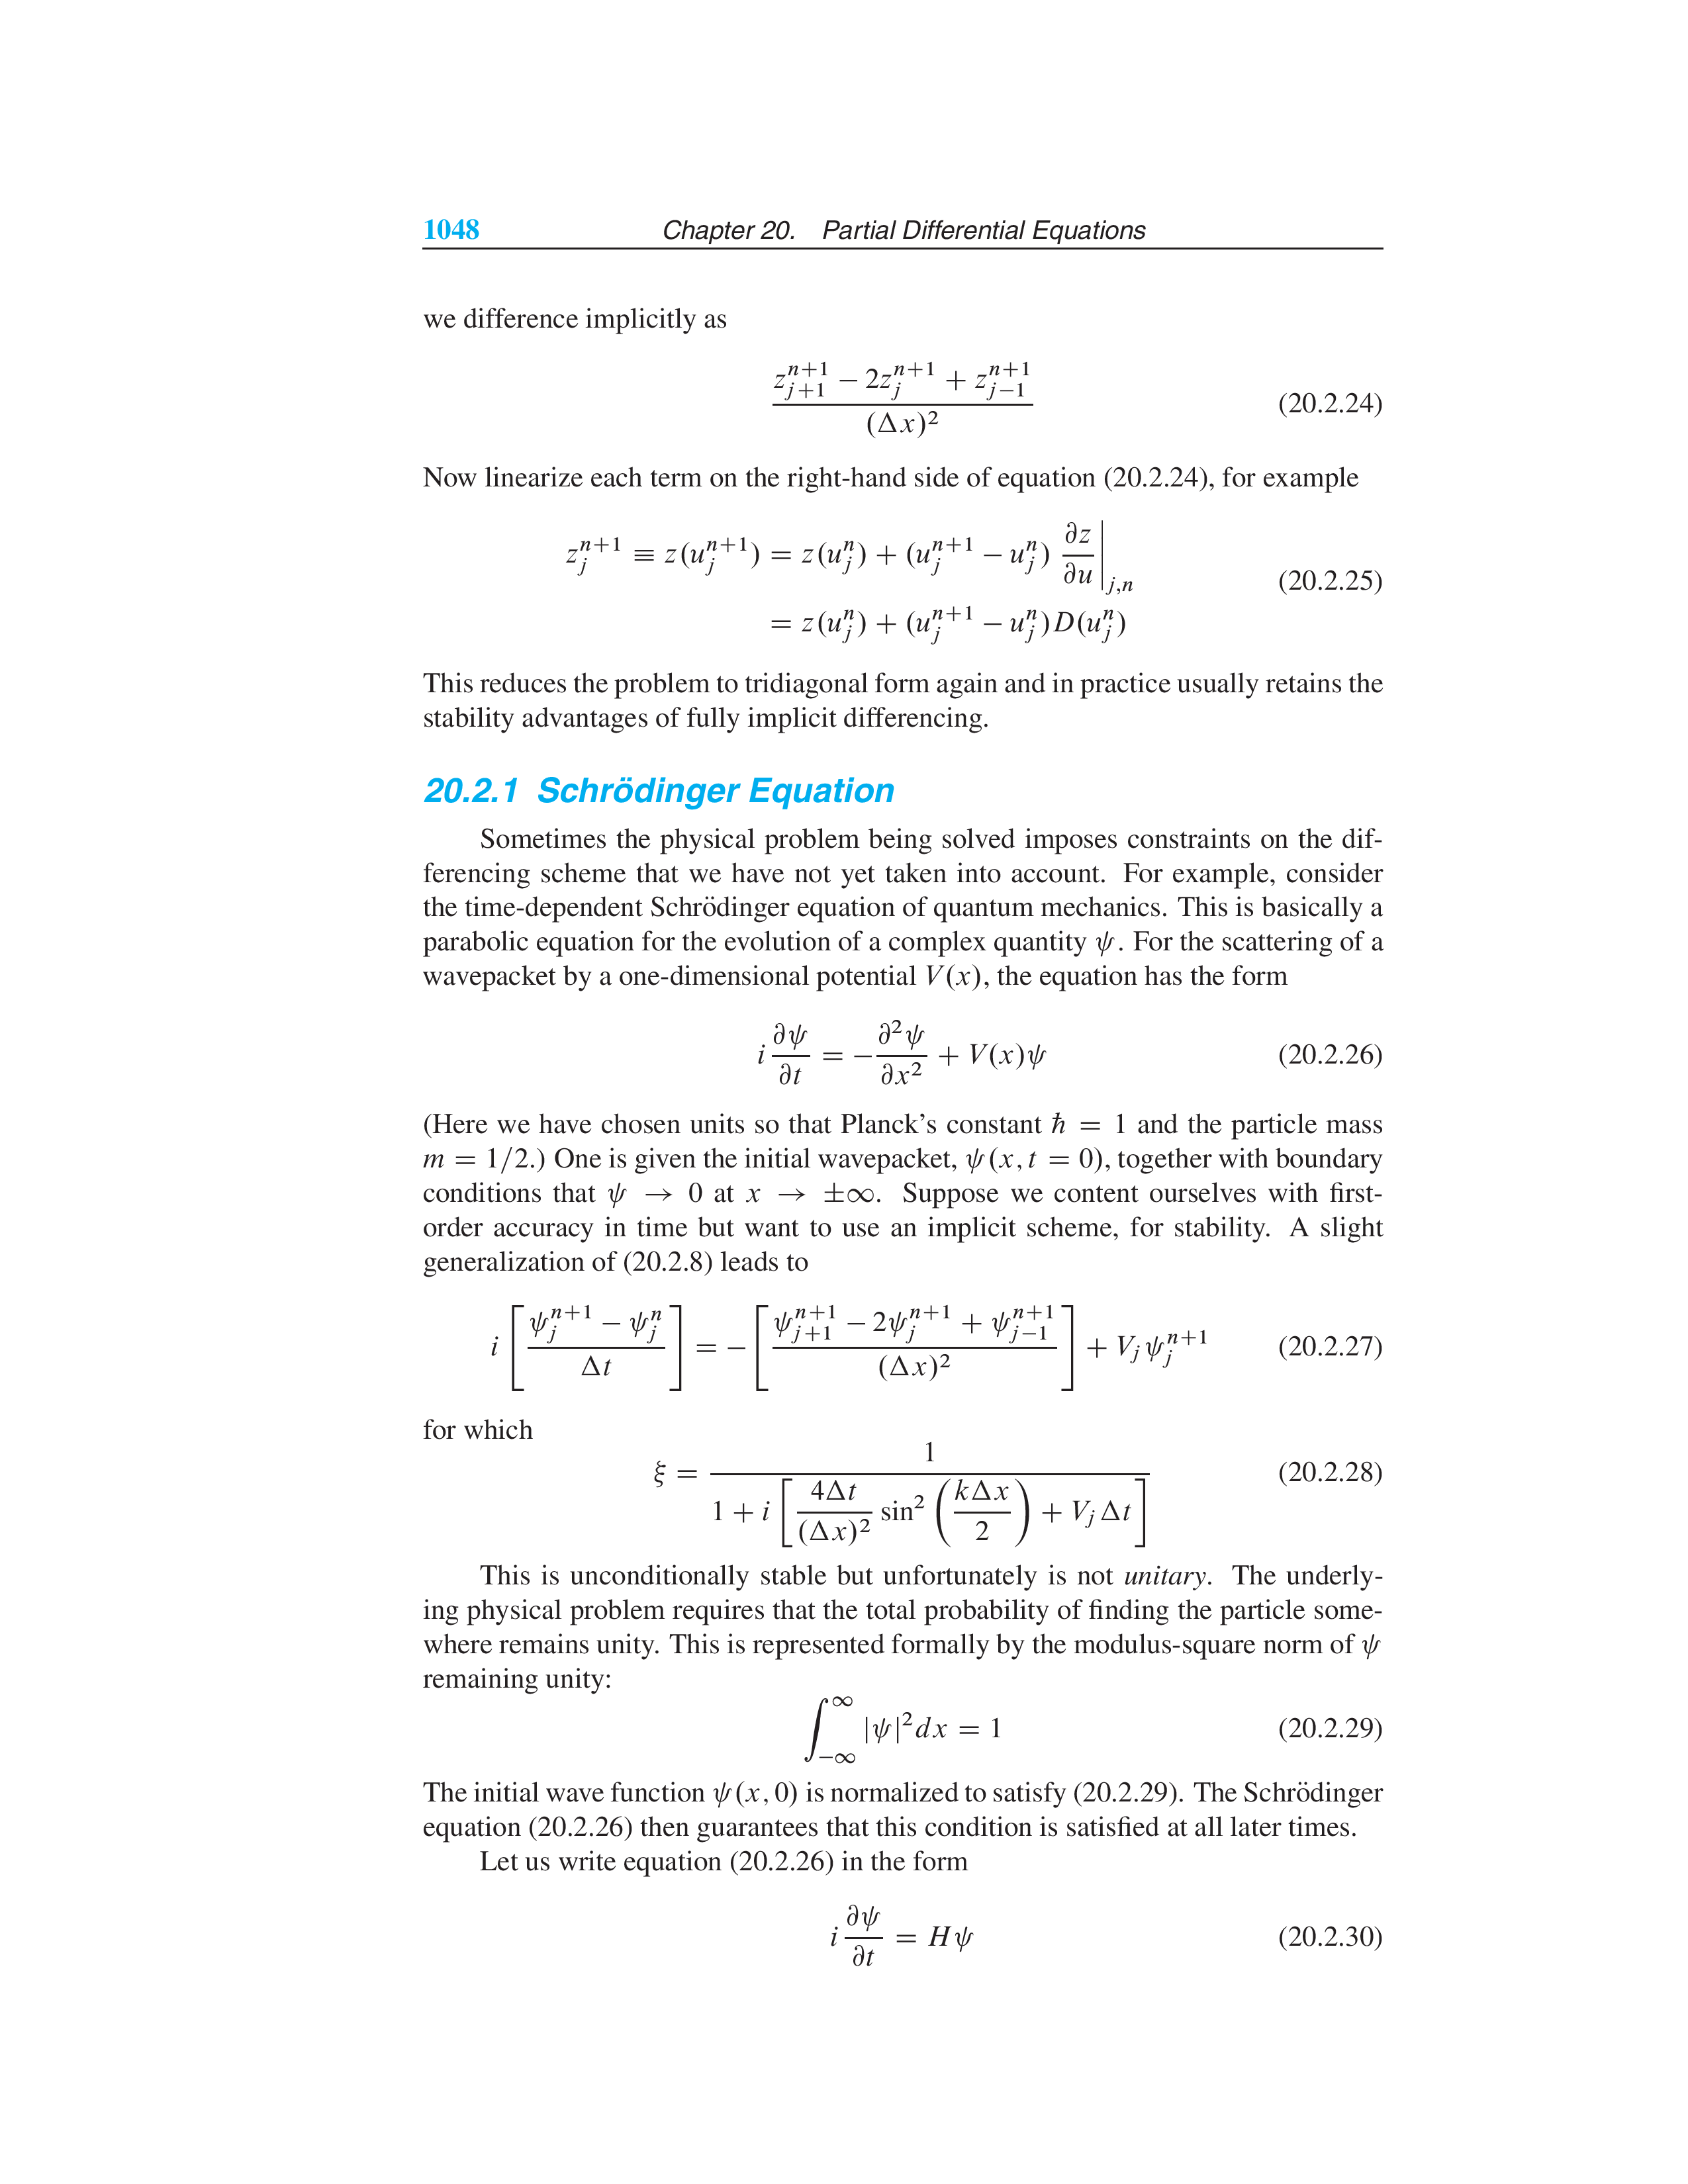


## Diffusion of heat through soil

As a (trivial) example, let's consider the diffusion of heat through soil.  (Soil isn't a good, homogeneous material- so a real case would require actual measurements of heat conductivity and heat capacity.  There is also a great deal of variation depending upon water content).  We will pick typical heat conductivities of $k=1$ W/mK,a heat capacity of $C=800$ J/kgK, and density $\rho=1300 \rm{kg/m}^3$.

The heat equation- which we can derive from the contnuity equation $\partial u/\partial t + \nabla \cdot q=0$ and Fourier's equation:  $q=-k\nabla T$, combined with $u=\rho CT$:
\begin{equation} \frac{\partial T}{\partial t}=\frac{k}{C\rho}\nabla^2T\rightarrow
\frac{k}{C\rho}\frac{\partial^2 T}{\partial x^2} \end{equation} in one dimension.  Here $u$ refers to the internal heat energy, $T$ to the temperature and $t$ to time.

We will start with a uniform temperature throughout the soil=T0=0 C, and then set the temperature at the surface to 10 C.  How long does it take for the temperature 3 meters down to drop to 9 C? (This we can actually solve analytically, but we won't, of course).

We make a grid of temperatures- with the first index that corresponds to depth and the second index to time:
\begin{equation}x=id_x; t=nd_t\end{equation}.  Let us start with a grid that goes 10 meters down, since we don't want to have boundary conditions at the bottom.

How big should the time steps be?  Crank Nicolson is stable for any stepo size, but we look to calculate a "natural step"- so for that we use $d_t<\frac{d_x^2}{2D}$- let's set $d_t=0.9\frac{d_x^2}{2D}$.  This choice would also allow us to use varying D (in which case we would use the minimum D to set the step.

In [35]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('figure',dpi=250)

k=1 #W/mK
C=800 #J/kg/K
rho=1300 #kg/m**3

D=k/(C*rho)

xrange=10 #m  -- how far into the soil we will calculate- start at 10 and double
interval=365*24*3600 #s  Guess- an interval over which we calculate the diffusion
nx=100 #number of bins
dx=xrange/nx
dt=dx**2/2/D
nt=int(interval/dt)

print('For diffusion coefficient D=%g and %d bins, dx=%f m and dt=%f s'%(D,nx,dx,dt))

For diffusion coefficient D=9.61538e-07 and 100 bins, dx=0.200000 m and dt=20800.000000 s


In [36]:
Temperature=np.ones((nx,nt)) # the array of temperatures

Temperature[1:,0]=0  # initial conditions is all soil beneath the surface is 0
Temperature[0,:]=10  #boundary condition-  at the surface the temperature is always 10


Now we use the Crank-Nicolsen equation to solve for temperatures at time n+1 given the temperatures at time n.  (I have changed notation here so $u=T$.

\begin{equation}\frac{u_j^{n+1}-u_j^n}{d_t}=\frac{D}{2}\frac{u_{j+1}^{n+1}-2u_j^{n+1}+u_{j-1}^{n+1} +u_{j+1}^n-2u_j^n+u_{j-1}^n}{d_x^2}\end{equation}

which we can rewrite --for the j-th row and defining $\alpha=\frac{2d_x^2}{Dd_t}$-- as
\begin{equation}(...,-1, \alpha+2, -1,...) \left( \begin{array}{c}
...\\
u_{j-1}^{n+1} \\
u_j^{n+1}  \\
u_{j+1}^{n+1}\\
... \\
\end{array}\right)=
(...,1, \alpha-2, 1,...) \left( \begin{array}{c}
...\\
u_{j-1}^n \\
u_j^n  \\
u_{j+1}^n\\
... \\
\end{array}\right)
\end{equation}

or, with $\mathbf{A}$ and $\mathbf{B}$ as the obvious matrices, we have$\mathbf{A}u^{n+1}=\mathbf{B}u^n$.

Thus, we end up with
\begin{equation}u^{n+1}=\mathbf{A^{-1}B}u^n\end{equation}

What about the first and last row?  They are actually set by the boundary conditions- and will simply be a (1,...)


In [37]:
alpha=2*dx**2/D/dt

A=np.zeros((nx,nx))
A[0,0]=1.0
B=np.zeros((nx,nx))
B[0,0]=1.0
for j in range(1,nx-1):
    A[j,j]=alpha+2
    A[j,j-1]=-1
    A[j,j+1]=-1
    B[j,j]=alpha-2
    B[j,j-1]=1
    B[j,j+1]=1
B[nx-1,nx-1]=1
A[nx-1,nx-1]=1

C=np.linalg.inv(A)
print (C)
print(np.dot(C,A))

C=np.dot(C,B)
print(C)

[[  1.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.71572875e-01   1.71572875e-01   2.94372515e-02 ...,   5.50985973e-75
    9.18309955e-76   9.18309955e-76]
 [  2.94372515e-02   2.94372515e-02   1.76623509e-01 ...,   3.30591584e-74
    5.50985973e-75   5.50985973e-75]
 ..., 
 [  5.50985973e-75   5.50985973e-75   3.30591584e-74 ...,   1.76623509e-01
    2.94372515e-02   2.94372515e-02]
 [  9.18309955e-76   9.18309955e-76   5.50985973e-75 ...,   2.94372515e-02
    1.71572875e-01   1.71572875e-01]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   1.00000000e+00]]
[[  1.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   1.00000000e+00   1.99493200e-17 ...,   1.35000070e-90
   -1.22727337e-90   0.00000000e+00]
 [  0.00000000e+00  -2.77555756e-17   1.00000000e+00 ...,   3.92727477e-90
   -7.85454954e-90   

And now we progress by simply multiplying each temperature distribution 

In [38]:
for n in range(1,nt):
    Temperature[:,n]=np.dot(C,Temperature[:,n-1])
    

In [39]:
#plot the temperature profile every month
x=np.linspace(0,xrange,nx)
month=nt/12
plt.figure()
for m in range(0,12):
    plt.plot(x,Temperature[:,int(m*month)])
plt.ylabel('Temperature')
plt.xlabel('Depth [m]')
plt.title('Temperature as a function of depth')

We double the depth to make sure that the lower boundary condition isn't causing a problem.

And we plot the temperature at a depth of 3 meters

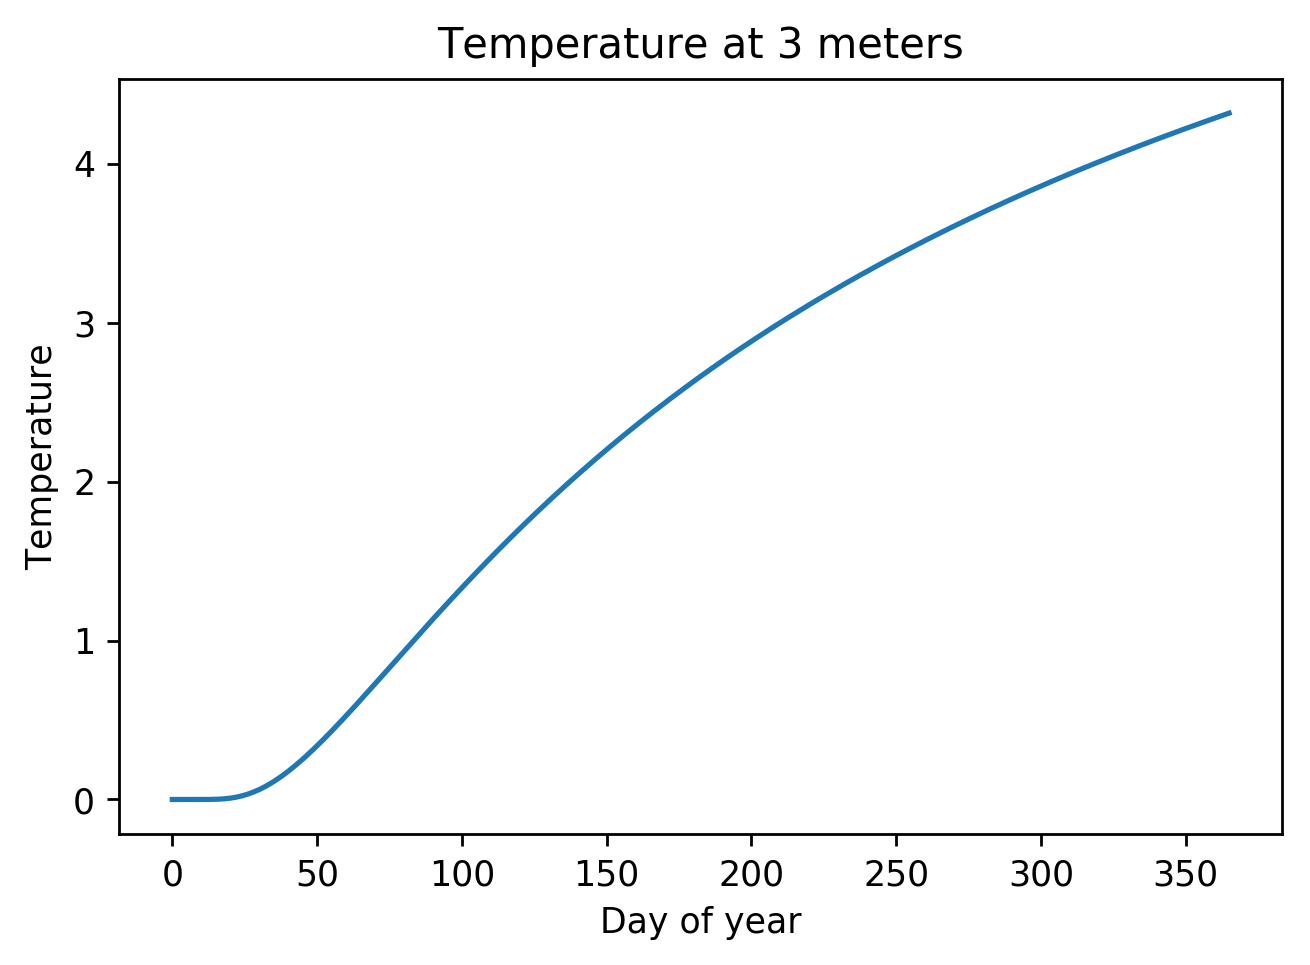

In [43]:
t=np.linspace(0,365,365)
plt.figure()
plt.plot(t,Temperature[30,0:365*int(nt/365):int(nt/365)])
plt.title('Temperature at 3 meters')
plt.xlabel('Day of year')
plt.ylabel('Temperature')

For fun, let's add an annual temperature variation.  Using Edmonton averages (2.5C with a swing of +/- 15 C), and we assume that the coldest day of the year is Jan 1.  

In [53]:
k=1 #W/mK
C=800 #J/kg/K
rho=1300 #kg/m**3

D=k/(C*rho)

xrange=10 #m  -- how far into the soil we will calculate- start at 10 and double
interval=2*365*24*3600 #s  Guess- an interval over which we calculate the diffusion
nx=100 #number of bins
dx=xrange/nx
dt=dx**2/2/D
nt=int(interval/dt)

print('For diffusion coefficient D=%g and %d bins, dx=%f m and dt=%f s'%(D,nx,dx,dt))

Temperature=np.ones((nx,nt)) # the array of temperatures
Temperature[1:,0]=2.5  # initial conditions is all soil beneath the surface is 0

def Temp(t):
    return 2.5-15*np.cos(t/(365*24*3600)*np.pi*2)
Temperature[0,:]=Temp(0)  #boundary condition-  at the surface the temperature is always 10

alpha=2*dx**2/D/dt
A=np.zeros((nx,nx))
A[0,0]=1.0
B=np.zeros((nx,nx))
B[0,0]=1.0
for j in range(1,nx-1):
    A[j,j]=alpha+2
    A[j,j-1]=-1
    A[j,j+1]=-1
    B[j,j]=alpha-2
    B[j,j-1]=1
    B[j,j+1]=1
B[nx-1,nx-1]=1
A[nx-1,nx-1]=1
C=np.dot(np.linalg.inv(A),B)

for n in range(1,nt):
    Temperature[:,n]=np.dot(C,Temperature[:,n-1])
    Temperature[0,n]=Temp(n*dt)
    

For diffusion coefficient D=9.61538e-07 and 100 bins, dx=0.100000 m and dt=5200.000000 s


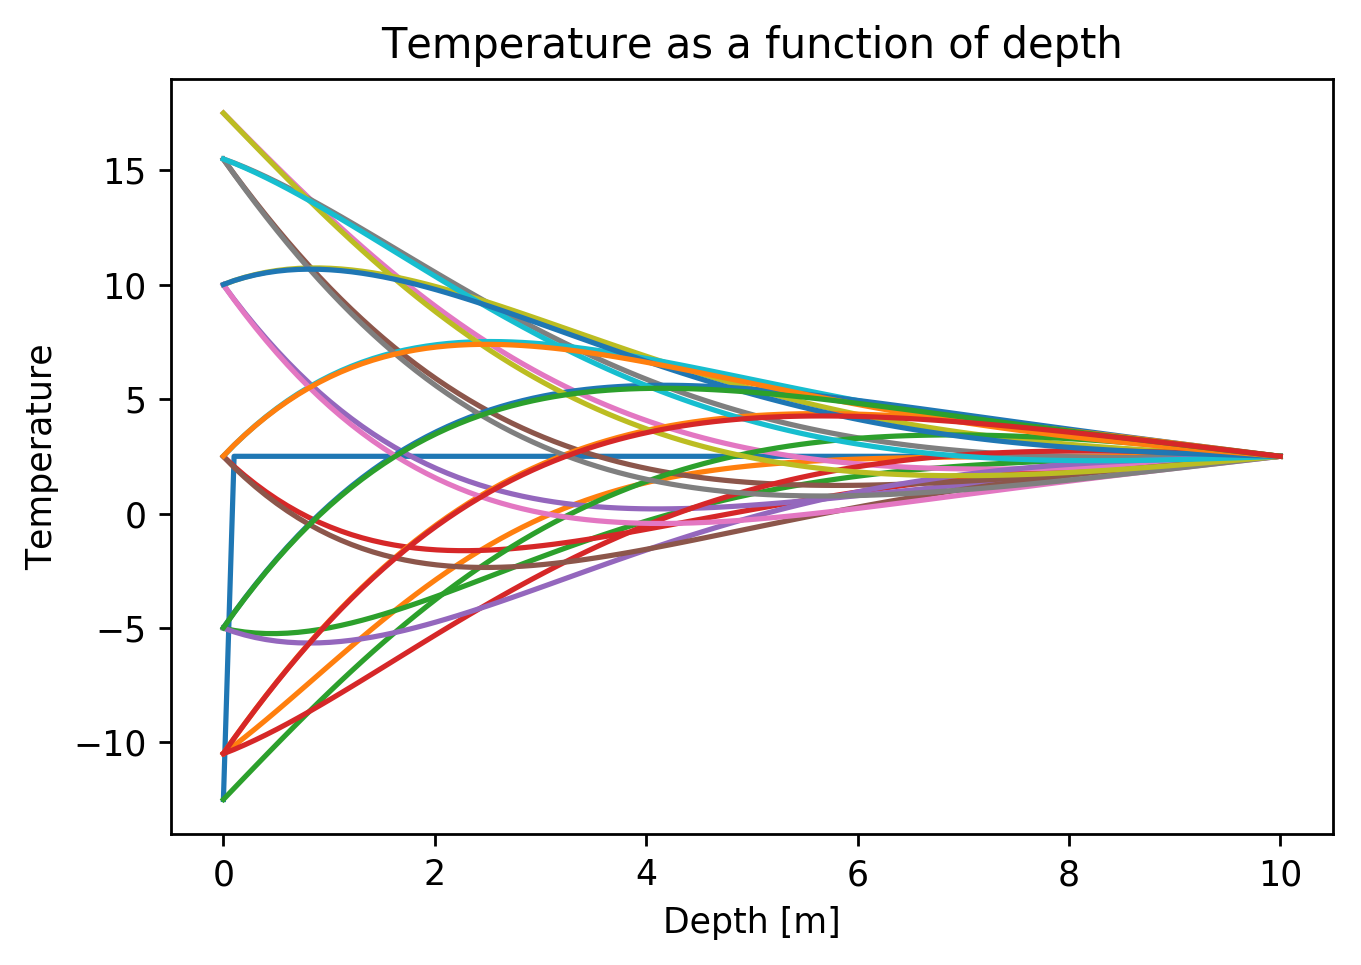

In [54]:
#plot the temperature profile every month
x=np.linspace(0,xrange,nx)
month=nt/24
plt.figure()
for m in range(0,24):
    plt.plot(x,Temperature[:,int(m*month)])
plt.ylabel('Temperature')
plt.xlabel('Depth [m]')
plt.title('Temperature as a function of depth')

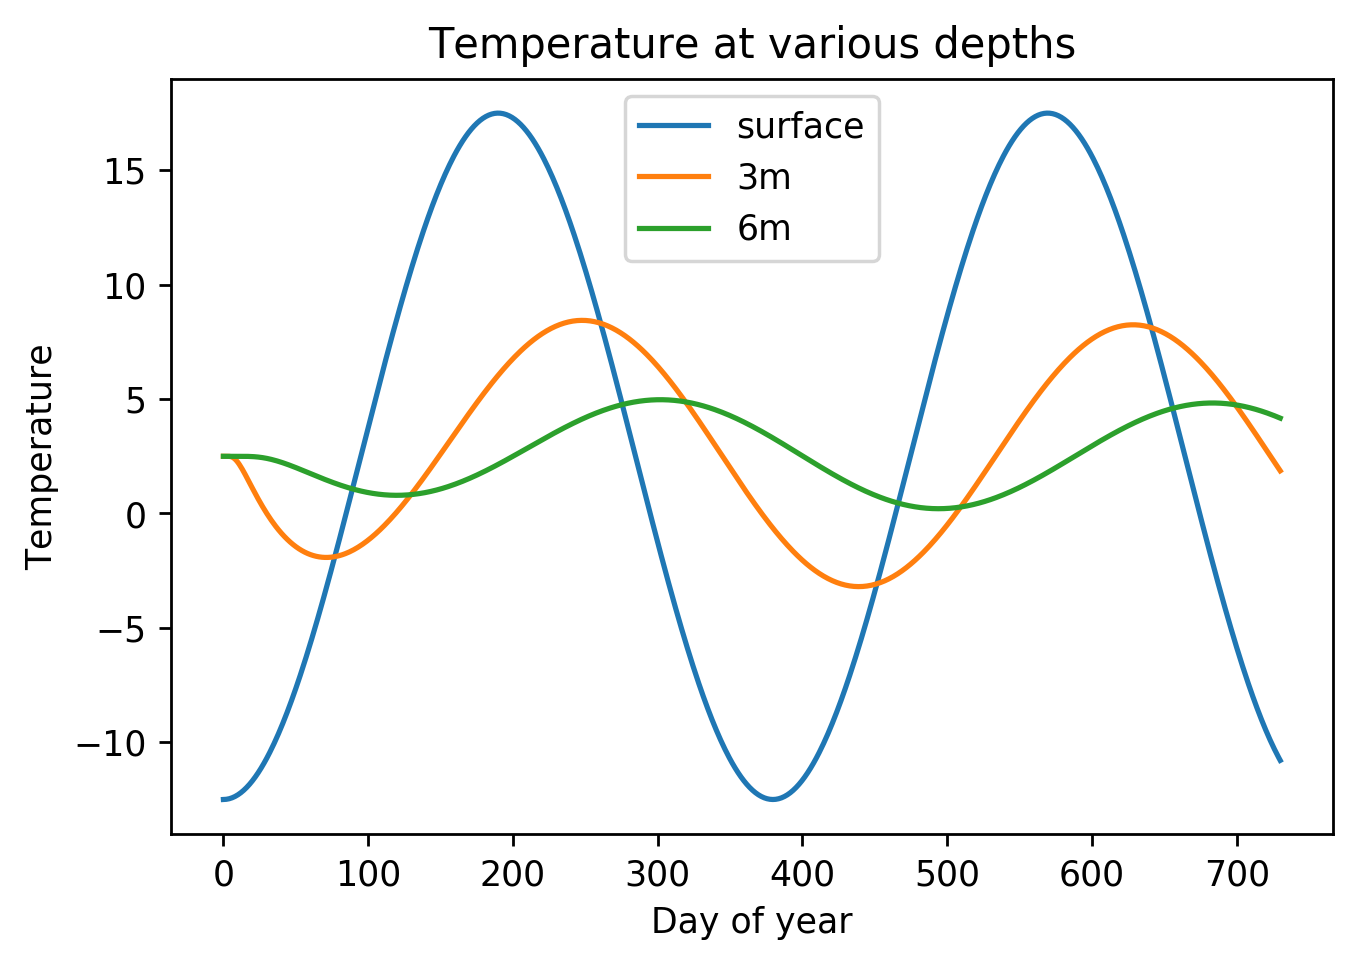

In [58]:
ndays=2*365
t=np.linspace(0,ndays,ndays)
plt.figure()
plt.plot(t,Temperature[0,0:ndays*int(nt/ndays):int(nt/ndays)],label='surface')
plt.plot(t,Temperature[30,0:ndays*int(nt/ndays):int(nt/ndays)],label='3m')
plt.plot(t,Temperature[60,0:ndays*int(nt/ndays):int(nt/ndays)],label='6m')
plt.legend()
plt.title('Temperature at various depths')
plt.xlabel('Day of year')
plt.ylabel('Temperature')